In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

train_dir = r"C:\iitb\SOC_2023_ESRGAN\Datasets\DIV2K_HR\DIV2K_train_HR\train\\"

for img in os.listdir(train_dir):
    img_array = cv2.imread(train_dir + img)
    
    img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(r"C:\iitb\SOC_2023_ESRGAN\Datasets\hr_images\\" + img, img_array)
    cv2.imwrite(r"C:\iitb\SOC_2023_ESRGAN\Datasets\lr_images\\" + img, lr_img_array)

In [2]:
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

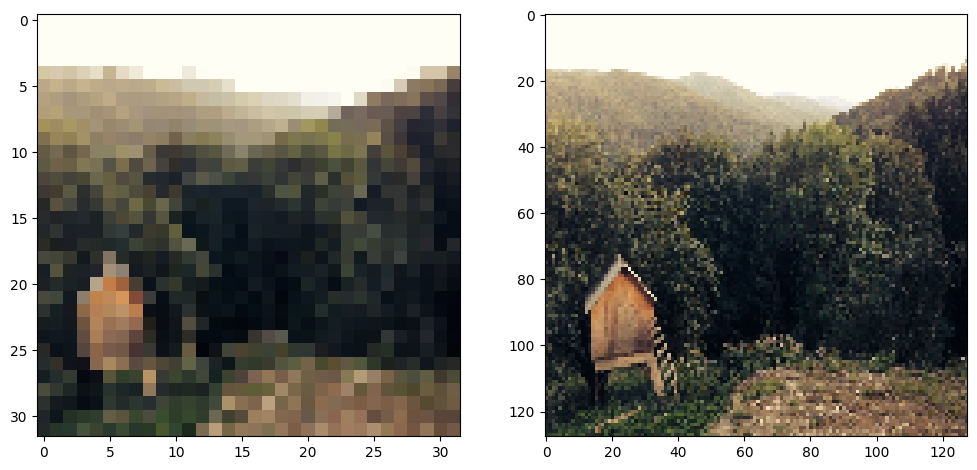

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [3]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

#Load first n number of images (to train on a subset of all images)
n=800
lr_list = os.listdir(r"C:\iitb\SOC_2023_ESRGAN\Datasets\lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread(r"C:\iitb\SOC_2023_ESRGAN\Datasets\lr_images\\" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir(r"C:\iitb\SOC_2023_ESRGAN\Datasets\hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread(r"C:\iitb\SOC_2023_ESRGAN\Datasets\hr_images\\" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

In [9]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 5
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 40
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 1s 618ms/step


  1%|          | 1/107 [00:05<09:51,  5.58s/it]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/107 [00:06<04:31,  2.59s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 3/107 [00:06<02:49,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 4/107 [00:07<02:01,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 5/107 [00:07<01:35,  1.07it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 6/107 [00:08<01:19,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 7/107 [00:08<01:08,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 8/107 [00:09<01:02,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 9/107 [00:09<00:57,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 10/107 [00:10<00:53,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 11/107 [00:10<00:50,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 12/107 [00:10<00:49,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 13/107 [00:11<00:48,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 14/107 [00:11<00:47,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 15/107 [00:12<00:46,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 16/107 [00:12<00:45,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 17/107 [00:13<00:45,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 18/107 [00:13<00:44,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 19/107 [00:14<00:43,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 20/107 [00:14<00:43,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 21/107 [00:15<00:42,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 22/107 [00:15<00:42,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 23/107 [00:16<00:41,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 24/107 [00:16<00:41,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 25/107 [00:17<00:40,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 26/107 [00:17<00:40,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 27/107 [00:18<00:39,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 28/107 [00:18<00:39,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 29/107 [00:19<00:38,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 30/107 [00:19<00:37,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 31/107 [00:20<00:37,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 32/107 [00:20<00:36,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 33/107 [00:21<00:36,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 34/107 [00:21<00:35,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 35/107 [00:22<00:36,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 36/107 [00:22<00:35,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 37/107 [00:23<00:34,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 38/107 [00:23<00:34,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 39/107 [00:24<00:33,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 40/107 [00:24<00:33,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 41/107 [00:25<00:32,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 42/107 [00:25<00:32,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 43/107 [00:26<00:31,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 44/107 [00:26<00:31,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 45/107 [00:27<00:30,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 46/107 [00:27<00:30,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 47/107 [00:28<00:29,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 48/107 [00:28<00:28,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 49/107 [00:29<00:29,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 50/107 [00:29<00:28,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 51/107 [00:30<00:27,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 52/107 [00:30<00:27,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 53/107 [00:31<00:26,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 54/107 [00:31<00:26,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 55/107 [00:32<00:25,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 56/107 [00:32<00:25,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 57/107 [00:33<00:24,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 58/107 [00:33<00:24,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 59/107 [00:34<00:23,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 60/107 [00:34<00:23,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 61/107 [00:35<00:23,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 62/107 [00:35<00:22,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 63/107 [00:36<00:22,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 64/107 [00:36<00:21,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 65/107 [00:37<00:21,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 66/107 [00:37<00:20,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 67/107 [00:38<00:20,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 68/107 [00:38<00:19,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 69/107 [00:39<00:19,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 70/107 [00:39<00:18,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 71/107 [00:40<00:18,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 72/107 [00:40<00:17,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 73/107 [00:41<00:17,  1.97it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 74/107 [00:42<00:18,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 75/107 [00:42<00:18,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 76/107 [00:43<00:17,  1.77it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 77/107 [00:43<00:17,  1.74it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 78/107 [00:44<00:16,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 79/107 [00:45<00:16,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 80/107 [00:45<00:15,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 81/107 [00:46<00:14,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 82/107 [00:46<00:14,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 83/107 [00:47<00:13,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 84/107 [00:47<00:12,  1.82it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 85/107 [00:48<00:12,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 86/107 [00:48<00:11,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 87/107 [00:49<00:10,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 88/107 [00:49<00:10,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 89/107 [00:50<00:09,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 90/107 [00:50<00:09,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 91/107 [00:51<00:08,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 92/107 [00:52<00:08,  1.78it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████▋ | 93/107 [00:52<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 94/107 [00:53<00:07,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 95/107 [00:53<00:06,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 96/107 [00:54<00:06,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 97/107 [00:54<00:05,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 98/107 [00:55<00:04,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 99/107 [00:56<00:04,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 100/107 [00:56<00:03,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 101/107 [00:57<00:03,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 102/107 [00:57<00:02,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 103/107 [00:58<00:02,  1.92it/s]

1/1 [==============================] - 0s 71ms/step


 97%|█████████▋| 104/107 [00:58<00:01,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 105/107 [00:59<00:01,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 106/107 [00:59<00:00,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 107/107 [01:00<00:00,  1.78it/s]


epoch: 1 g_loss: 82.54969734120591 d_loss: [2.79243072 0.72897197]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 1/107 [00:00<00:53,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 2/107 [00:01<00:52,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 3/107 [00:01<00:51,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 4/107 [00:01<00:51,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 5/107 [00:02<00:50,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 6/107 [00:02<00:49,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 7/107 [00:03<00:50,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.98it/s]

1/1 [==============================] - 0s 55ms/step


  8%|▊         | 9/107 [00:04<00:54,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 10/107 [00:05<00:58,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 11/107 [00:05<00:55,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 12/107 [00:06<00:54,  1.75it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 13/107 [00:07<00:55,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 14/107 [00:07<00:53,  1.74it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 15/107 [00:08<00:54,  1.68it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▍        | 16/107 [00:08<00:55,  1.64it/s]

1/1 [==============================] - 0s 63ms/step


 16%|█▌        | 17/107 [00:09<00:56,  1.59it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█▋        | 18/107 [00:10<01:01,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 19/107 [00:10<00:56,  1.56it/s]

1/1 [==============================] - 0s 68ms/step


 19%|█▊        | 20/107 [00:11<00:58,  1.48it/s]

1/1 [==============================] - 0s 77ms/step


 20%|█▉        | 21/107 [00:12<00:58,  1.48it/s]

1/1 [==============================] - 0s 55ms/step


 21%|██        | 22/107 [00:13<00:58,  1.45it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██▏       | 23/107 [00:13<00:58,  1.42it/s]

1/1 [==============================] - 0s 61ms/step


 22%|██▏       | 24/107 [00:14<00:59,  1.39it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 25/107 [00:15<00:58,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 26/107 [00:15<00:55,  1.47it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 27/107 [00:16<00:53,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 28/107 [00:17<00:49,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 29/107 [00:17<00:45,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 30/107 [00:18<00:43,  1.78it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 31/107 [00:18<00:46,  1.64it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 32/107 [00:19<00:47,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 33/107 [00:20<00:48,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 34/107 [00:20<00:46,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 35/107 [00:21<00:44,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 36/107 [00:21<00:41,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 37/107 [00:22<00:39,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 38/107 [00:22<00:37,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 39/107 [00:23<00:36,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 40/107 [00:23<00:34,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 41/107 [00:24<00:35,  1.87it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 42/107 [00:25<00:37,  1.71it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 43/107 [00:25<00:40,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 44/107 [00:26<00:39,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 45/107 [00:27<00:38,  1.61it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 46/107 [00:27<00:39,  1.53it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 47/107 [00:28<00:39,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 48/107 [00:29<00:39,  1.48it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 49/107 [00:29<00:38,  1.50it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 50/107 [00:30<00:37,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 51/107 [00:31<00:35,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 52/107 [00:31<00:33,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 53/107 [00:32<00:31,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 54/107 [00:32<00:29,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 55/107 [00:33<00:28,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 56/107 [00:33<00:27,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 57/107 [00:34<00:26,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 58/107 [00:34<00:25,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 59/107 [00:35<00:26,  1.78it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 60/107 [00:36<00:28,  1.64it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 61/107 [00:36<00:29,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 62/107 [00:37<00:29,  1.53it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 63/107 [00:38<00:29,  1.51it/s]

1/1 [==============================] - 0s 64ms/step


 60%|█████▉    | 64/107 [00:38<00:28,  1.48it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 65/107 [00:39<00:28,  1.48it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 66/107 [00:40<00:28,  1.42it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 67/107 [00:40<00:28,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 68/107 [00:41<00:26,  1.48it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 69/107 [00:42<00:25,  1.51it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 70/107 [00:42<00:24,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 71/107 [00:43<00:22,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 72/107 [00:44<00:21,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 73/107 [00:44<00:20,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 74/107 [00:45<00:19,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 75/107 [00:45<00:18,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 76/107 [00:46<00:16,  1.83it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 77/107 [00:46<00:17,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 78/107 [00:47<00:16,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 79/107 [00:47<00:15,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 80/107 [00:48<00:14,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 81/107 [00:48<00:14,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 82/107 [00:49<00:13,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 83/107 [00:50<00:13,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 84/107 [00:50<00:12,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 85/107 [00:51<00:11,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 86/107 [00:51<00:11,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 87/107 [00:52<00:10,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 88/107 [00:52<00:10,  1.87it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 89/107 [00:53<00:09,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 90/107 [00:53<00:09,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 91/107 [00:54<00:08,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 92/107 [00:54<00:07,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 93/107 [00:55<00:07,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 94/107 [00:56<00:07,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 95/107 [00:56<00:06,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 96/107 [00:57<00:06,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 97/107 [00:57<00:05,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 98/107 [00:58<00:04,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 99/107 [00:58<00:04,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 100/107 [00:59<00:03,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 101/107 [00:59<00:03,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 102/107 [01:00<00:02,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 103/107 [01:00<00:02,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 104/107 [01:01<00:01,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 105/107 [01:01<00:01,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 106/107 [01:02<00:00,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 107/107 [01:02<00:00,  1.70it/s]


epoch: 2 g_loss: 66.25711662078572 d_loss: [0.49661383 0.91962617]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 1/107 [00:00<00:54,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 2/107 [00:01<00:55,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 3/107 [00:01<00:54,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 4/107 [00:02<00:53,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 5/107 [00:02<00:51,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 6/107 [00:03<00:51,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 7/107 [00:03<00:52,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 8/107 [00:04<00:51,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 9/107 [00:04<00:51,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 10/107 [00:05<00:50,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 11/107 [00:05<00:50,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 12/107 [00:06<00:50,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 13/107 [00:06<00:49,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 14/107 [00:07<00:47,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 15/107 [00:07<00:47,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 16/107 [00:08<00:47,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 17/107 [00:08<00:46,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 18/107 [00:09<00:45,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 19/107 [00:09<00:44,  1.98it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 20/107 [00:10<00:45,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 21/107 [00:10<00:45,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 22/107 [00:11<00:45,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 23/107 [00:11<00:44,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 24/107 [00:12<00:42,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 25/107 [00:12<00:41,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 26/107 [00:13<00:40,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 27/107 [00:13<00:40,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 28/107 [00:14<00:40,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 29/107 [00:15<00:40,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 30/107 [00:15<00:40,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 31/107 [00:16<00:39,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 32/107 [00:16<00:38,  1.93it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███       | 33/107 [00:17<00:39,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 34/107 [00:17<00:38,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 35/107 [00:18<00:37,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 36/107 [00:18<00:36,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 37/107 [00:19<00:35,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 38/107 [00:19<00:35,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 39/107 [00:20<00:34,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 40/107 [00:20<00:33,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 41/107 [00:21<00:33,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 42/107 [00:21<00:32,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 43/107 [00:22<00:31,  2.01it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 44/107 [00:22<00:31,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 45/107 [00:23<00:31,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 46/107 [00:23<00:30,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 47/107 [00:24<00:29,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 48/107 [00:24<00:29,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 49/107 [00:25<00:28,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 50/107 [00:25<00:28,  2.00it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 51/107 [00:26<00:28,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 52/107 [00:26<00:28,  1.95it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 53/107 [00:27<00:28,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 54/107 [00:27<00:27,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 55/107 [00:28<00:27,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 56/107 [00:28<00:26,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 57/107 [00:29<00:25,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 58/107 [00:29<00:24,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 59/107 [00:30<00:24,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 60/107 [00:30<00:23,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 61/107 [00:31<00:22,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 62/107 [00:31<00:21,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 63/107 [00:32<00:21,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 64/107 [00:32<00:21,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 65/107 [00:33<00:21,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 66/107 [00:33<00:20,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 67/107 [00:34<00:19,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 68/107 [00:34<00:19,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 69/107 [00:35<00:18,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 70/107 [00:35<00:18,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 71/107 [00:36<00:17,  2.04it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 72/107 [00:36<00:17,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 73/107 [00:37<00:17,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 74/107 [00:37<00:16,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 75/107 [00:38<00:16,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 76/107 [00:38<00:16,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 77/107 [00:39<00:15,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 78/107 [00:39<00:14,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 79/107 [00:40<00:13,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 80/107 [00:40<00:13,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 81/107 [00:41<00:12,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 82/107 [00:41<00:12,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 83/107 [00:42<00:11,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 84/107 [00:42<00:11,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 85/107 [00:43<00:11,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 86/107 [00:43<00:11,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 87/107 [00:44<00:10,  1.91it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 88/107 [00:44<00:10,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 89/107 [00:45<00:09,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 90/107 [00:45<00:08,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 91/107 [00:46<00:08,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 92/107 [00:46<00:07,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 93/107 [00:47<00:07,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 94/107 [00:48<00:06,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 95/107 [00:48<00:06,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 96/107 [00:49<00:05,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 97/107 [00:49<00:05,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 98/107 [00:50<00:04,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 99/107 [00:50<00:04,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 100/107 [00:51<00:03,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 101/107 [00:51<00:03,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 102/107 [00:52<00:02,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 103/107 [00:52<00:02,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 104/107 [00:53<00:01,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 105/107 [00:53<00:00,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 106/107 [00:54<00:00,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 107/107 [00:54<00:00,  1.96it/s]


epoch: 3 g_loss: 61.06860715206538 d_loss: [0.12240495 0.96542056]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/107 [00:00<00:55,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 2/107 [00:01<00:53,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 3/107 [00:01<00:51,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 4/107 [00:01<00:51,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 5/107 [00:02<00:51,  1.99it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 6/107 [00:03<00:53,  1.87it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 7/107 [00:03<00:55,  1.81it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 8/107 [00:04<00:58,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 9/107 [00:04<00:55,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 10/107 [00:05<00:53,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 11/107 [00:05<00:51,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 12/107 [00:06<00:49,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 13/107 [00:06<00:47,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 14/107 [00:07<00:46,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 15/107 [00:07<00:45,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 16/107 [00:08<00:45,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 17/107 [00:08<00:44,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 18/107 [00:09<00:43,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 19/107 [00:09<00:44,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 20/107 [00:10<00:43,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 21/107 [00:10<00:42,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 22/107 [00:11<00:41,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 23/107 [00:11<00:40,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 24/107 [00:12<00:40,  2.07it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 25/107 [00:12<00:39,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 26/107 [00:13<00:38,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 27/107 [00:13<00:38,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 28/107 [00:14<00:38,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 29/107 [00:14<00:37,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 30/107 [00:15<00:36,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 31/107 [00:15<00:36,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 32/107 [00:16<00:35,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 33/107 [00:16<00:35,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 34/107 [00:17<00:34,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 35/107 [00:17<00:34,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 36/107 [00:18<00:35,  2.00it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 37/107 [00:18<00:36,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 38/107 [00:19<00:37,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 39/107 [00:19<00:35,  1.91it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 40/107 [00:20<00:35,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 41/107 [00:20<00:34,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 42/107 [00:21<00:33,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 43/107 [00:21<00:32,  1.98it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 44/107 [00:22<00:34,  1.83it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 45/107 [00:23<00:35,  1.73it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 46/107 [00:23<00:38,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 47/107 [00:24<00:36,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 48/107 [00:24<00:34,  1.70it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 49/107 [00:25<00:35,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 50/107 [00:26<00:32,  1.74it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 51/107 [00:26<00:32,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 52/107 [00:27<00:30,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 53/107 [00:27<00:29,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 54/107 [00:28<00:29,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 55/107 [00:28<00:29,  1.76it/s]

1/1 [==============================] - 0s 85ms/step


 52%|█████▏    | 56/107 [00:29<00:33,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 57/107 [00:30<00:32,  1.55it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 58/107 [00:31<00:33,  1.47it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 59/107 [00:31<00:33,  1.45it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 60/107 [00:32<00:32,  1.43it/s]

1/1 [==============================] - 0s 79ms/step


 57%|█████▋    | 61/107 [00:33<00:33,  1.39it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 62/107 [00:33<00:32,  1.40it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 63/107 [00:34<00:31,  1.39it/s]

1/1 [==============================] - 0s 66ms/step


 60%|█████▉    | 64/107 [00:35<00:31,  1.38it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 65/107 [00:36<00:28,  1.48it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 66/107 [00:36<00:28,  1.46it/s]

1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 67/107 [00:37<00:28,  1.41it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████▎   | 68/107 [00:38<00:28,  1.38it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 69/107 [00:38<00:27,  1.37it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 70/107 [00:39<00:26,  1.38it/s]

1/1 [==============================] - 0s 68ms/step


 66%|██████▋   | 71/107 [00:40<00:25,  1.39it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 72/107 [00:41<00:25,  1.36it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 73/107 [00:41<00:25,  1.35it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 74/107 [00:42<00:25,  1.32it/s]

1/1 [==============================] - 0s 72ms/step


 70%|███████   | 75/107 [00:43<00:24,  1.30it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████   | 76/107 [00:44<00:23,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 77/107 [00:44<00:21,  1.42it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 78/107 [00:45<00:20,  1.41it/s]

1/1 [==============================] - 0s 71ms/step


 74%|███████▍  | 79/107 [00:46<00:19,  1.41it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 80/107 [00:46<00:18,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 81/107 [00:47<00:16,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 82/107 [00:47<00:15,  1.63it/s]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 83/107 [00:48<00:14,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 84/107 [00:49<00:13,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [00:49<00:12,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 86/107 [00:50<00:11,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 87/107 [00:50<00:11,  1.80it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 88/107 [00:51<00:11,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 89/107 [00:51<00:10,  1.76it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 90/107 [00:52<00:09,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 91/107 [00:53<00:09,  1.74it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 92/107 [00:53<00:08,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 93/107 [00:54<00:07,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 94/107 [00:54<00:07,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 95/107 [00:55<00:06,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 96/107 [00:55<00:05,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 97/107 [00:56<00:05,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 98/107 [00:56<00:04,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 99/107 [00:57<00:04,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 100/107 [00:57<00:03,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 101/107 [00:58<00:02,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:58<00:02,  2.02it/s]

1/1 [==============================] - 0s 71ms/step


 96%|█████████▋| 103/107 [00:59<00:02,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:59<00:01,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [01:00<00:00,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [01:00<00:00,  2.02it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 107/107 [01:01<00:00,  1.75it/s]


epoch: 4 g_loss: 60.190113531094845 d_loss: [0.44049383 0.90093458]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:50,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/107 [00:01<00:53,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 3/107 [00:01<00:53,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 4/107 [00:02<00:51,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<00:50,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 6/107 [00:02<00:49,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 7/107 [00:03<00:48,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 8/107 [00:03<00:48,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 9/107 [00:04<00:47,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 10/107 [00:04<00:47,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:05<00:47,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:05<00:46,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:46,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 14/107 [00:06<00:45,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:07<00:44,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 16/107 [00:07<00:44,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:08<00:43,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:08<00:43,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:09<00:42,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 20/107 [00:09<00:41,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 21/107 [00:10<00:41,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 22/107 [00:10<00:40,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:11<00:40,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 24/107 [00:11<00:39,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:12<00:38,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 26/107 [00:12<00:39,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:13<00:38,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:13<00:37,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 29/107 [00:14<00:37,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 30/107 [00:14<00:36,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 31/107 [00:15<00:35,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 32/107 [00:15<00:35,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:15<00:34,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 34/107 [00:16<00:34,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 35/107 [00:16<00:34,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:17<00:33,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:17<00:33,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 38/107 [00:18<00:32,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 39/107 [00:18<00:32,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 40/107 [00:19<00:31,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 41/107 [00:19<00:31,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 42/107 [00:20<00:31,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 43/107 [00:20<00:30,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 44/107 [00:21<00:30,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 45/107 [00:21<00:29,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 46/107 [00:22<00:29,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 47/107 [00:22<00:28,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 48/107 [00:23<00:28,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:23<00:28,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 50/107 [00:24<00:27,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:24<00:26,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 52/107 [00:25<00:26,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 53/107 [00:25<00:25,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 54/107 [00:26<00:25,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 55/107 [00:26<00:24,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 56/107 [00:26<00:24,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 57/107 [00:27<00:23,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 58/107 [00:27<00:23,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 59/107 [00:28<00:22,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 60/107 [00:28<00:22,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 61/107 [00:29<00:21,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 62/107 [00:29<00:21,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:30<00:20,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 64/107 [00:30<00:20,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 65/107 [00:31<00:20,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 66/107 [00:31<00:19,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:32<00:19,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 68/107 [00:32<00:18,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 69/107 [00:33<00:18,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:33<00:17,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 71/107 [00:34<00:17,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 72/107 [00:34<00:16,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 73/107 [00:35<00:16,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:35<00:15,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 75/107 [00:36<00:15,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:36<00:14,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 77/107 [00:37<00:14,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:37<00:14,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 79/107 [00:38<00:13,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 80/107 [00:38<00:12,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [00:38<00:12,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [00:39<00:11,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 83/107 [00:39<00:11,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 84/107 [00:40<00:10,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [00:40<00:10,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 86/107 [00:41<00:10,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 87/107 [00:41<00:09,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 88/107 [00:42<00:09,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 89/107 [00:42<00:08,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [00:43<00:08,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:43<00:07,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 92/107 [00:44<00:07,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [00:44<00:06,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 94/107 [00:45<00:06,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [00:45<00:05,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 96/107 [00:46<00:05,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 97/107 [00:46<00:04,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:47<00:04,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 99/107 [00:47<00:03,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [00:48<00:03,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 101/107 [00:48<00:02,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:49<00:02,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 103/107 [00:49<00:01,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 104/107 [00:49<00:01,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [00:50<00:00,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 106/107 [00:50<00:00,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 107/107 [00:51<00:00,  2.08it/s]

epoch: 5 g_loss: 56.29167442678291 d_loss: [0.03073571 0.98878505]



  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 1/107 [00:00<00:50,  2.11it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 2/107 [00:00<00:52,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 3/107 [00:01<00:53,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 4/107 [00:01<00:51,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:55,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:52,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 7/107 [00:03<00:53,  1.87it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 8/107 [00:04<01:00,  1.64it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 9/107 [00:05<01:03,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 10/107 [00:05<01:05,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 11/107 [00:06<01:04,  1.48it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 12/107 [00:07<01:05,  1.44it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 13/107 [00:08<01:07,  1.40it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 14/107 [00:08<01:06,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 15/107 [00:09<01:06,  1.38it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 16/107 [00:10<01:05,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 17/107 [00:10<01:00,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 18/107 [00:11<00:56,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 19/107 [00:11<00:51,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 20/107 [00:12<00:48,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 21/107 [00:12<00:46,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 22/107 [00:13<00:44,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 23/107 [00:13<00:43,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 24/107 [00:14<00:42,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 25/107 [00:14<00:41,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 26/107 [00:15<00:41,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 27/107 [00:15<00:40,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 28/107 [00:16<00:39,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 29/107 [00:16<00:39,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 30/107 [00:17<00:38,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 31/107 [00:17<00:38,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 32/107 [00:18<00:38,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 33/107 [00:18<00:37,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 34/107 [00:19<00:36,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 35/107 [00:19<00:36,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 36/107 [00:20<00:35,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 37/107 [00:20<00:34,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 38/107 [00:21<00:34,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 39/107 [00:21<00:33,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 40/107 [00:22<00:32,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 41/107 [00:22<00:32,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 42/107 [00:23<00:31,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 43/107 [00:23<00:31,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 44/107 [00:24<00:30,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 45/107 [00:24<00:30,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 46/107 [00:25<00:29,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 47/107 [00:25<00:29,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 48/107 [00:26<00:28,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 49/107 [00:26<00:28,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 50/107 [00:27<00:27,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 51/107 [00:27<00:27,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 52/107 [00:28<00:27,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 53/107 [00:28<00:26,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 54/107 [00:29<00:25,  2.05it/s]

1/1 [==============================] - 0s 61ms/step


 51%|█████▏    | 55/107 [00:29<00:28,  1.80it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 56/107 [00:30<00:30,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 57/107 [00:31<00:30,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 58/107 [00:31<00:27,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:32<00:27,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 60/107 [00:32<00:26,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 61/107 [00:33<00:24,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 62/107 [00:33<00:23,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 63/107 [00:34<00:23,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 64/107 [00:34<00:22,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 65/107 [00:35<00:21,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 66/107 [00:35<00:20,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 67/107 [00:36<00:19,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 68/107 [00:36<00:19,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 69/107 [00:37<00:19,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 70/107 [00:37<00:18,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 71/107 [00:38<00:17,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 72/107 [00:38<00:17,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 73/107 [00:39<00:16,  2.00it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 74/107 [00:39<00:18,  1.80it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 75/107 [00:40<00:19,  1.67it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 76/107 [00:41<00:19,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 77/107 [00:41<00:17,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 78/107 [00:42<00:16,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 79/107 [00:42<00:14,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 80/107 [00:43<00:14,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 81/107 [00:43<00:13,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 82/107 [00:44<00:13,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 83/107 [00:44<00:12,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 84/107 [00:45<00:11,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 85/107 [00:45<00:11,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 86/107 [00:46<00:10,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 87/107 [00:46<00:09,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 88/107 [00:47<00:09,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 89/107 [00:47<00:09,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 90/107 [00:48<00:09,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 91/107 [00:48<00:08,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 92/107 [00:49<00:07,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 93/107 [00:49<00:07,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 94/107 [00:50<00:06,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 95/107 [00:50<00:06,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 96/107 [00:51<00:05,  1.96it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 97/107 [00:51<00:05,  1.90it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 98/107 [00:52<00:04,  1.90it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 99/107 [00:53<00:04,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 100/107 [00:53<00:03,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 101/107 [00:54<00:03,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 102/107 [00:54<00:02,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 103/107 [00:55<00:02,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 104/107 [00:55<00:01,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 105/107 [00:56<00:01,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 106/107 [00:56<00:00,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 107/107 [00:57<00:00,  1.87it/s]


epoch: 6 g_loss: 53.59649825764593 d_loss: [0.08290376 0.98130841]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 1/107 [00:00<00:55,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 2/107 [00:01<00:55,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 3/107 [00:01<00:53,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 4/107 [00:02<00:54,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 5/107 [00:02<00:52,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 6/107 [00:03<00:52,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 7/107 [00:03<00:51,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 9/107 [00:04<00:49,  1.97it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▉         | 10/107 [00:05<00:50,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 11/107 [00:05<00:50,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 12/107 [00:06<00:49,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 13/107 [00:06<00:48,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 14/107 [00:07<00:47,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 15/107 [00:07<00:46,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 16/107 [00:08<00:46,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:08<00:46,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 18/107 [00:09<00:47,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 19/107 [00:09<00:47,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 20/107 [00:10<00:47,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 21/107 [00:11<00:49,  1.74it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 22/107 [00:11<00:47,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 23/107 [00:12<00:45,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 24/107 [00:12<00:44,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 25/107 [00:13<00:44,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 26/107 [00:13<00:44,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 27/107 [00:14<00:44,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 28/107 [00:14<00:44,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 29/107 [00:15<00:42,  1.83it/s]

1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 30/107 [00:15<00:42,  1.80it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 31/107 [00:16<00:42,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 32/107 [00:17<00:41,  1.80it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███       | 33/107 [00:17<00:42,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 34/107 [00:18<00:40,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 35/107 [00:18<00:39,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 36/107 [00:19<00:38,  1.84it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 37/107 [00:19<00:38,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 38/107 [00:20<00:37,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 39/107 [00:20<00:35,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 40/107 [00:21<00:34,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 41/107 [00:21<00:32,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 42/107 [00:22<00:32,  1.99it/s]

1/1 [==============================] - 0s 7ms/step


 40%|████      | 43/107 [00:22<00:31,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 44/107 [00:23<00:31,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 45/107 [00:23<00:30,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 46/107 [00:24<00:29,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 47/107 [00:24<00:29,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 48/107 [00:25<00:28,  2.05it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 49/107 [00:25<00:30,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 50/107 [00:26<00:29,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 51/107 [00:26<00:28,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 52/107 [00:27<00:27,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 53/107 [00:27<00:28,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 54/107 [00:28<00:27,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 55/107 [00:28<00:26,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 56/107 [00:29<00:26,  1.95it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 57/107 [00:30<00:30,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:30<00:29,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 59/107 [00:31<00:27,  1.74it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 60/107 [00:31<00:27,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 61/107 [00:32<00:26,  1.75it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 62/107 [00:33<00:25,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 63/107 [00:33<00:24,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 64/107 [00:34<00:23,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 65/107 [00:34<00:22,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 66/107 [00:35<00:21,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 67/107 [00:35<00:20,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 68/107 [00:36<00:19,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 69/107 [00:36<00:19,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:37<00:18,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 71/107 [00:37<00:17,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 72/107 [00:38<00:17,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 73/107 [00:38<00:16,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 74/107 [00:39<00:16,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 75/107 [00:39<00:15,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 76/107 [00:40<00:15,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 77/107 [00:40<00:14,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 78/107 [00:40<00:14,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 79/107 [00:41<00:13,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 80/107 [00:41<00:13,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 81/107 [00:42<00:12,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [00:42<00:12,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 83/107 [00:43<00:11,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:43<00:10,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [00:44<00:10,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [00:44<00:10,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 87/107 [00:45<00:09,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 88/107 [00:45<00:09,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:46<00:08,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [00:46<00:08,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:47<00:07,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 92/107 [00:47<00:07,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 93/107 [00:48<00:06,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 94/107 [00:48<00:06,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 95/107 [00:49<00:05,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 96/107 [00:49<00:05,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:50<00:04,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 98/107 [00:50<00:04,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 99/107 [00:51<00:03,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 100/107 [00:51<00:03,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [00:52<00:02,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:52<00:02,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 103/107 [00:53<00:01,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 104/107 [00:53<00:01,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [00:54<00:00,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [00:54<00:00,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 107/107 [00:55<00:00,  1.95it/s]


epoch: 7 g_loss: 51.328943163435035 d_loss: [0.16254325 0.96168224]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:52,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:00<00:51,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 3/107 [00:01<00:50,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 4/107 [00:01<00:49,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:48,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/107 [00:02<00:48,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 7/107 [00:03<00:47,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 8/107 [00:03<00:47,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:46,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:04<00:46,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 11/107 [00:05<00:45,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 12/107 [00:05<00:45,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 13/107 [00:06<00:44,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 14/107 [00:06<00:44,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:07<00:43,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 16/107 [00:07<00:43,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 17/107 [00:08<00:43,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 18/107 [00:08<00:42,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 19/107 [00:09<00:41,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 20/107 [00:09<00:41,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:10<00:40,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:10<00:40,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 23/107 [00:11<00:40,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 24/107 [00:11<00:39,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 25/107 [00:11<00:38,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 26/107 [00:12<00:38,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:12<00:38,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:13<00:37,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 29/107 [00:13<00:37,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 30/107 [00:14<00:36,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 31/107 [00:14<00:36,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 32/107 [00:15<00:35,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 33/107 [00:15<00:35,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 34/107 [00:16<00:35,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 35/107 [00:16<00:34,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 36/107 [00:17<00:33,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 37/107 [00:17<00:33,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 38/107 [00:18<00:33,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 39/107 [00:18<00:33,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:19<00:32,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:19<00:32,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 42/107 [00:20<00:31,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 43/107 [00:20<00:30,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 44/107 [00:21<00:30,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:21<00:29,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:22<00:29,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:22<00:28,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 48/107 [00:23<00:28,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 49/107 [00:23<00:28,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:23<00:27,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:24<00:27,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 52/107 [00:24<00:26,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 53/107 [00:25<00:25,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:25<00:25,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 55/107 [00:26<00:25,  2.06it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 56/107 [00:26<00:24,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 57/107 [00:27<00:23,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 58/107 [00:27<00:23,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:28<00:23,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 60/107 [00:28<00:22,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:29<00:22,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 62/107 [00:29<00:21,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 63/107 [00:30<00:20,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 64/107 [00:30<00:20,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 65/107 [00:31<00:20,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 66/107 [00:31<00:19,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:32<00:18,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 68/107 [00:32<00:18,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:33<00:18,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 70/107 [00:33<00:17,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 71/107 [00:34<00:17,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 72/107 [00:34<00:16,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 73/107 [00:35<00:16,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:35<00:15,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 75/107 [00:35<00:15,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 76/107 [00:36<00:14,  2.07it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 77/107 [00:36<00:14,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 78/107 [00:37<00:14,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 79/107 [00:37<00:13,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 80/107 [00:38<00:12,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [00:38<00:12,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [00:39<00:12,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 83/107 [00:39<00:11,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 84/107 [00:40<00:11,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 85/107 [00:40<00:10,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 86/107 [00:41<00:10,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 87/107 [00:41<00:09,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 88/107 [00:42<00:09,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 89/107 [00:42<00:08,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [00:43<00:08,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [00:43<00:07,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:44<00:07,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 93/107 [00:44<00:06,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 94/107 [00:45<00:06,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 95/107 [00:45<00:05,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 96/107 [00:46<00:05,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 97/107 [00:46<00:04,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 98/107 [00:47<00:04,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 99/107 [00:47<00:03,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 100/107 [00:48<00:03,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [00:48<00:02,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 102/107 [00:49<00:02,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [00:49<00:01,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 104/107 [00:49<00:01,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 105/107 [00:50<00:00,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [00:50<00:00,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 107/107 [00:51<00:00,  2.08it/s]


epoch: 8 g_loss: 49.81374031138197 d_loss: [0.01726344 0.99813084]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 1/107 [00:00<00:54,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 2/107 [00:01<00:52,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 3/107 [00:01<00:52,  1.99it/s]

1/1 [==============================] - 0s 109ms/step


  4%|▎         | 4/107 [00:02<01:00,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<00:55,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:53,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 7/107 [00:03<00:52,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 8/107 [00:04<00:52,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 9/107 [00:04<00:51,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 10/107 [00:05<00:52,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 11/107 [00:05<00:52,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 12/107 [00:06<00:53,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 13/107 [00:07<00:51,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 14/107 [00:07<00:50,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 15/107 [00:08<00:52,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 16/107 [00:08<00:52,  1.75it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 17/107 [00:09<00:53,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 18/107 [00:10<00:52,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 19/107 [00:10<00:50,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 20/107 [00:11<00:49,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 21/107 [00:11<00:50,  1.69it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 22/107 [00:12<00:52,  1.62it/s]

1/1 [==============================] - 0s 55ms/step


 21%|██▏       | 23/107 [00:13<00:51,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 24/107 [00:13<00:48,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 25/107 [00:14<00:46,  1.77it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 26/107 [00:14<00:44,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 27/107 [00:15<00:44,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 28/107 [00:15<00:44,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 29/107 [00:16<00:42,  1.84it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 30/107 [00:16<00:43,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 31/107 [00:17<00:41,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:17<00:39,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:18<00:38,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 34/107 [00:18<00:37,  1.95it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 35/107 [00:19<00:37,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 36/107 [00:19<00:37,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 37/107 [00:20<00:36,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 38/107 [00:20<00:35,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 39/107 [00:21<00:35,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 40/107 [00:21<00:34,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 41/107 [00:22<00:33,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 42/107 [00:22<00:32,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 43/107 [00:23<00:32,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:24<00:34,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:24<00:34,  1.81it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 46/107 [00:25<00:32,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:25<00:31,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 48/107 [00:26<00:30,  1.96it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 49/107 [00:26<00:30,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:27<00:29,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 51/107 [00:27<00:28,  1.99it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▊     | 52/107 [00:28<00:28,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 53/107 [00:28<00:27,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 54/107 [00:29<00:27,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 55/107 [00:29<00:26,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 56/107 [00:30<00:25,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 57/107 [00:30<00:25,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 58/107 [00:31<00:24,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 59/107 [00:31<00:26,  1.78it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 60/107 [00:32<00:27,  1.72it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 61/107 [00:33<00:29,  1.59it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 62/107 [00:34<00:29,  1.50it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 63/107 [00:34<00:31,  1.41it/s]

1/1 [==============================] - 0s 74ms/step


 60%|█████▉    | 64/107 [00:35<00:31,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 65/107 [00:36<00:29,  1.43it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 66/107 [00:36<00:28,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:37<00:25,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 68/107 [00:38<00:24,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 69/107 [00:38<00:21,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 70/107 [00:38<00:20,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 71/107 [00:39<00:19,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 72/107 [00:39<00:18,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 73/107 [00:40<00:17,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 74/107 [00:40<00:16,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [00:41<00:16,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:41<00:15,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 77/107 [00:42<00:14,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 78/107 [00:42<00:14,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 79/107 [00:43<00:13,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 80/107 [00:43<00:13,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [00:44<00:12,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 82/107 [00:44<00:12,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 83/107 [00:45<00:11,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 84/107 [00:45<00:11,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 85/107 [00:46<00:10,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [00:46<00:10,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 87/107 [00:47<00:09,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 88/107 [00:47<00:09,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 89/107 [00:48<00:08,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [00:48<00:08,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:49<00:07,  2.10it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 92/107 [00:49<00:07,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 93/107 [00:50<00:06,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 94/107 [00:50<00:06,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 95/107 [00:51<00:05,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 96/107 [00:51<00:05,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:52<00:04,  2.01it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 98/107 [00:52<00:04,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 99/107 [00:53<00:04,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 100/107 [00:53<00:03,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [00:54<00:03,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 102/107 [00:54<00:02,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 103/107 [00:55<00:02,  1.90it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 104/107 [00:55<00:01,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 105/107 [00:56<00:01,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 106/107 [00:57<00:00,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [00:57<00:00,  1.86it/s]


epoch: 9 g_loss: 48.38723252198407 d_loss: [1.85258718e-08 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 1/107 [00:00<01:06,  1.59it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 2/107 [00:01<01:06,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<01:05,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 4/107 [00:02<01:00,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<00:59,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:59,  1.69it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 7/107 [00:04<01:00,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<01:01,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 9/107 [00:05<00:59,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:06<00:58,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 11/107 [00:06<00:55,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 12/107 [00:07<00:54,  1.74it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 13/107 [00:07<00:55,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 14/107 [00:08<00:54,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:08<00:53,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 16/107 [00:09<00:51,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 17/107 [00:09<00:50,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 18/107 [00:10<00:47,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 19/107 [00:10<00:45,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:11<00:44,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 21/107 [00:11<00:44,  1.93it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 22/107 [00:12<00:47,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 23/107 [00:13<00:44,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 24/107 [00:13<00:43,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 25/107 [00:14<00:41,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 26/107 [00:14<00:41,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 27/107 [00:15<00:40,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:15<00:40,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:16<00:41,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 30/107 [00:16<00:40,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 31/107 [00:17<00:38,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 32/107 [00:17<00:38,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:18<00:39,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 34/107 [00:18<00:38,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 35/107 [00:19<00:38,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:19<00:37,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 37/107 [00:20<00:36,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 38/107 [00:20<00:34,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 39/107 [00:21<00:35,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 40/107 [00:21<00:33,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:22<00:32,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 42/107 [00:22<00:32,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 43/107 [00:23<00:32,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 44/107 [00:23<00:32,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 45/107 [00:24<00:31,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:24<00:30,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:25<00:29,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 48/107 [00:25<00:29,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:26<00:29,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 50/107 [00:26<00:28,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:27<00:27,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 52/107 [00:27<00:27,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 53/107 [00:28<00:26,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:28<00:26,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 55/107 [00:29<00:26,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 56/107 [00:29<00:26,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 57/107 [00:30<00:25,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 58/107 [00:30<00:24,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:31<00:23,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 60/107 [00:31<00:23,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:32<00:23,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 62/107 [00:33<00:24,  1.86it/s]

1/1 [==============================] - 0s 92ms/step


 59%|█████▉    | 63/107 [00:34<00:37,  1.17it/s]

1/1 [==============================] - 0s 50ms/step


 60%|█████▉    | 64/107 [00:35<00:35,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 65/107 [00:35<00:31,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 66/107 [00:36<00:27,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:36<00:25,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 68/107 [00:37<00:25,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 69/107 [00:38<00:23,  1.58it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▌   | 70/107 [00:39<00:27,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 71/107 [00:39<00:23,  1.52it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 72/107 [00:40<00:24,  1.45it/s]

1/1 [==============================] - 0s 86ms/step


 68%|██████▊   | 73/107 [00:41<00:24,  1.38it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 74/107 [00:42<00:25,  1.29it/s]

1/1 [==============================] - 0s 87ms/step


 70%|███████   | 75/107 [00:43<00:26,  1.21it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████   | 76/107 [00:43<00:25,  1.23it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 77/107 [00:44<00:24,  1.23it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 78/107 [00:45<00:22,  1.26it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 79/107 [00:46<00:22,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 80/107 [00:46<00:18,  1.43it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 81/107 [00:47<00:16,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 82/107 [00:47<00:15,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 83/107 [00:48<00:13,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 84/107 [00:48<00:12,  1.78it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▉  | 85/107 [00:49<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 86/107 [00:50<00:12,  1.68it/s]

1/1 [==============================] - 0s 69ms/step


 81%|████████▏ | 87/107 [00:50<00:13,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 88/107 [00:51<00:12,  1.54it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████▎ | 89/107 [00:52<00:10,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 90/107 [00:52<00:09,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 91/107 [00:53<00:08,  1.81it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 92/107 [00:53<00:08,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [00:54<00:07,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 94/107 [00:54<00:06,  1.89it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 95/107 [00:55<00:07,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 96/107 [00:55<00:06,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 97/107 [00:56<00:05,  1.75it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 98/107 [00:57<00:05,  1.58it/s]

1/1 [==============================] - 0s 70ms/step


 93%|█████████▎| 99/107 [00:58<00:05,  1.44it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 100/107 [00:58<00:04,  1.41it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▍| 101/107 [00:59<00:04,  1.35it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 102/107 [01:00<00:03,  1.34it/s]

1/1 [==============================] - 0s 77ms/step


 96%|█████████▋| 103/107 [01:01<00:02,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [01:01<00:02,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [01:02<00:01,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 106/107 [01:02<00:00,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 107/107 [01:03<00:00,  1.70it/s]

epoch: 10 g_loss: 47.44694975380585 d_loss: [0.01716751 0.99719626]



  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:50,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:00<00:50,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 3/107 [00:01<00:52,  1.99it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 4/107 [00:01<00:51,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<00:50,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/107 [00:02<00:49,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 7/107 [00:03<00:48,  2.07it/s]

1/1 [==============================] - 0s 78ms/step


  7%|▋         | 8/107 [00:03<00:49,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 9/107 [00:04<00:50,  1.94it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 10/107 [00:05<00:50,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 11/107 [00:05<00:49,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 12/107 [00:06<00:50,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 13/107 [00:06<00:48,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 14/107 [00:07<00:49,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:07<00:48,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 16/107 [00:08<00:47,  1.90it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 17/107 [00:08<00:46,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 18/107 [00:09<00:46,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:09<00:45,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 20/107 [00:10<00:46,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:10<00:44,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 22/107 [00:11<00:43,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 23/107 [00:11<00:42,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 24/107 [00:12<00:43,  1.92it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 25/107 [00:12<00:44,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 26/107 [00:13<00:42,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 27/107 [00:14<00:47,  1.69it/s]

1/1 [==============================] - 0s 82ms/step


 26%|██▌       | 28/107 [00:14<00:48,  1.63it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 29/107 [00:15<00:52,  1.48it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 30/107 [00:16<00:53,  1.43it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 31/107 [00:17<00:57,  1.33it/s]

1/1 [==============================] - 0s 78ms/step


 30%|██▉       | 32/107 [00:18<01:00,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:18<00:54,  1.35it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 34/107 [00:19<00:50,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 35/107 [00:19<00:46,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:20<00:42,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:20<00:41,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 38/107 [00:21<00:40,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 39/107 [00:22<00:38,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:22<00:36,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:23<00:35,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 42/107 [00:23<00:33,  1.92it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 43/107 [00:24<00:35,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 44/107 [00:24<00:34,  1.83it/s]

1/1 [==============================] - 0s 78ms/step


 42%|████▏     | 45/107 [00:25<00:38,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:26<00:37,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 47/107 [00:26<00:35,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 48/107 [00:27<00:34,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 49/107 [00:27<00:33,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 50/107 [00:28<00:33,  1.72it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 51/107 [00:28<00:32,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:29<00:32,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 53/107 [00:30<00:32,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 54/107 [00:30<00:31,  1.69it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 55/107 [00:31<00:29,  1.74it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 56/107 [00:31<00:30,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 57/107 [00:32<00:28,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 58/107 [00:32<00:27,  1.79it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 59/107 [00:33<00:27,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 60/107 [00:34<00:26,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 61/107 [00:34<00:25,  1.80it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 62/107 [00:35<00:24,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 63/107 [00:35<00:23,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 64/107 [00:36<00:23,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 65/107 [00:36<00:22,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 66/107 [00:37<00:21,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 67/107 [00:37<00:21,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 68/107 [00:38<00:20,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 69/107 [00:38<00:20,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:39<00:20,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 71/107 [00:40<00:20,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 72/107 [00:40<00:20,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 73/107 [00:41<00:19,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:41<00:18,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 75/107 [00:42<00:17,  1.78it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 76/107 [00:43<00:18,  1.71it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 77/107 [00:43<00:18,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 78/107 [00:44<00:17,  1.64it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 79/107 [00:44<00:17,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 80/107 [00:45<00:16,  1.62it/s]

1/1 [==============================] - 0s 111ms/step


 76%|███████▌  | 81/107 [00:46<00:17,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 82/107 [00:47<00:16,  1.47it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 83/107 [00:47<00:17,  1.36it/s]

1/1 [==============================] - 0s 100ms/step


 79%|███████▊  | 84/107 [00:48<00:17,  1.30it/s]

1/1 [==============================] - 0s 164ms/step


 79%|███████▉  | 85/107 [00:50<00:22,  1.03s/it]

1/1 [==============================] - 0s 98ms/step


 80%|████████  | 86/107 [00:51<00:22,  1.07s/it]

1/1 [==============================] - 0s 98ms/step


 81%|████████▏ | 87/107 [00:52<00:21,  1.09s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████▏ | 88/107 [00:54<00:22,  1.17s/it]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 89/107 [00:54<00:17,  1.00it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [00:55<00:14,  1.16it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 91/107 [00:55<00:12,  1.26it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 92/107 [00:56<00:11,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [00:57<00:10,  1.39it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 94/107 [00:57<00:08,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [00:58<00:07,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 96/107 [00:58<00:06,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 97/107 [00:59<00:05,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:59<00:05,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 99/107 [01:01<00:06,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 100/107 [01:01<00:05,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 101/107 [01:02<00:04,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 102/107 [01:02<00:03,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 103/107 [01:03<00:02,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 104/107 [01:03<00:01,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 105/107 [01:04<00:01,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 106/107 [01:04<00:00,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 107/107 [01:05<00:00,  1.63it/s]


epoch: 11 g_loss: 46.57683481234256 d_loss: [2.8424583e-04 1.0000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 1/107 [00:00<00:53,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 2/107 [00:01<00:52,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 3/107 [00:01<00:51,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 4/107 [00:02<00:52,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 5/107 [00:02<00:50,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 6/107 [00:02<00:49,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 7/107 [00:03<00:49,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 9/107 [00:04<00:50,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 10/107 [00:05<00:51,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 11/107 [00:05<00:50,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 12/107 [00:06<00:51,  1.85it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 13/107 [00:06<00:56,  1.67it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 14/107 [00:07<01:03,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 15/107 [00:08<00:59,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 16/107 [00:08<00:55,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 17/107 [00:09<00:52,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 18/107 [00:09<00:49,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 19/107 [00:10<00:50,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 20/107 [00:11<00:48,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 21/107 [00:11<00:47,  1.82it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 22/107 [00:12<00:49,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 23/107 [00:12<00:50,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 24/107 [00:13<00:46,  1.77it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 25/107 [00:13<00:47,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 26/107 [00:14<00:46,  1.75it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 27/107 [00:15<00:46,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 28/107 [00:15<00:44,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 29/107 [00:16<00:43,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 30/107 [00:16<00:41,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 31/107 [00:17<00:41,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 32/107 [00:17<00:39,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 33/107 [00:18<00:39,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 34/107 [00:18<00:38,  1.92it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 35/107 [00:19<00:40,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 36/107 [00:19<00:40,  1.75it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 37/107 [00:20<00:43,  1.60it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 38/107 [00:21<00:43,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 39/107 [00:21<00:42,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 40/107 [00:22<00:46,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 41/107 [00:23<00:44,  1.47it/s]

1/1 [==============================] - 0s 82ms/step


 39%|███▉      | 42/107 [00:24<00:45,  1.44it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 43/107 [00:24<00:43,  1.47it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 44/107 [00:25<00:42,  1.48it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 45/107 [00:26<00:40,  1.53it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 46/107 [00:26<00:38,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 47/107 [00:27<00:37,  1.60it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 48/107 [00:28<00:37,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 49/107 [00:28<00:36,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 50/107 [00:29<00:36,  1.57it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 51/107 [00:30<00:37,  1.49it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 52/107 [00:30<00:35,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 53/107 [00:31<00:33,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 54/107 [00:31<00:33,  1.61it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 55/107 [00:32<00:33,  1.54it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 56/107 [00:33<00:32,  1.59it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 57/107 [00:33<00:32,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 58/107 [00:34<00:32,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 59/107 [00:35<00:33,  1.45it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 60/107 [00:35<00:31,  1.51it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 61/107 [00:36<00:30,  1.53it/s]

1/1 [==============================] - 0s 98ms/step


 58%|█████▊    | 62/107 [00:37<00:30,  1.50it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 63/107 [00:37<00:28,  1.53it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 64/107 [00:38<00:27,  1.54it/s]

1/1 [==============================] - 0s 71ms/step


 61%|██████    | 65/107 [00:39<00:30,  1.39it/s]

1/1 [==============================] - 0s 85ms/step


 62%|██████▏   | 66/107 [00:40<00:35,  1.15it/s]

1/1 [==============================] - 0s 77ms/step


 63%|██████▎   | 67/107 [00:41<00:35,  1.11it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▎   | 68/107 [00:42<00:33,  1.15it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 69/107 [00:43<00:31,  1.21it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 70/107 [00:43<00:30,  1.22it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▋   | 71/107 [00:44<00:28,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 72/107 [00:45<00:24,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 73/107 [00:45<00:21,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 74/107 [00:46<00:19,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 75/107 [00:46<00:17,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 76/107 [00:46<00:16,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 77/107 [00:47<00:15,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 78/107 [00:48<00:15,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 79/107 [00:48<00:14,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 80/107 [00:49<00:14,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 81/107 [00:49<00:13,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 82/107 [00:50<00:12,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 83/107 [00:50<00:12,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 84/107 [00:51<00:11,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 85/107 [00:51<00:10,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 86/107 [00:52<00:10,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 87/107 [00:52<00:09,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 88/107 [00:52<00:09,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 89/107 [00:53<00:08,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 90/107 [00:54<00:08,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 91/107 [00:54<00:07,  2.01it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 92/107 [00:55<00:08,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 93/107 [00:55<00:07,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 94/107 [00:56<00:06,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [00:56<00:06,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 96/107 [00:57<00:05,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 97/107 [00:57<00:05,  1.86it/s]

1/1 [==============================] - 0s 88ms/step


 92%|█████████▏| 98/107 [00:58<00:05,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 99/107 [00:59<00:04,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 100/107 [00:59<00:03,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 101/107 [01:00<00:03,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 102/107 [01:00<00:02,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 103/107 [01:01<00:02,  1.88it/s]

1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 104/107 [01:01<00:01,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 105/107 [01:02<00:01,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 106/107 [01:02<00:00,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 107/107 [01:03<00:00,  1.69it/s]


epoch: 12 g_loss: 45.59171580377026 d_loss: [1.8115821e-06 1.0000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/107 [00:00<00:58,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 2/107 [00:01<00:55,  1.91it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 3/107 [00:01<00:53,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 4/107 [00:02<00:53,  1.94it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 5/107 [00:02<00:53,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 6/107 [00:03<00:52,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 7/107 [00:03<00:51,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 8/107 [00:04<00:52,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:51,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 10/107 [00:05<00:50,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 11/107 [00:05<00:49,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 12/107 [00:06<00:49,  1.92it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 13/107 [00:06<00:53,  1.76it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 14/107 [00:07<00:56,  1.65it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 15/107 [00:08<01:01,  1.50it/s]

1/1 [==============================] - 0s 90ms/step


 15%|█▍        | 16/107 [00:09<01:03,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 17/107 [00:09<00:57,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 18/107 [00:10<00:54,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 19/107 [00:10<00:52,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 20/107 [00:11<00:49,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 21/107 [00:11<00:48,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 22/107 [00:12<00:47,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 23/107 [00:12<00:45,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 24/107 [00:13<00:43,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 25/107 [00:13<00:42,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 26/107 [00:14<00:41,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 27/107 [00:14<00:41,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 28/107 [00:15<00:40,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 29/107 [00:15<00:39,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 30/107 [00:16<00:38,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 31/107 [00:16<00:38,  1.97it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 32/107 [00:17<00:38,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 33/107 [00:18<00:38,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 34/107 [00:18<00:38,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 35/107 [00:19<00:37,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 36/107 [00:19<00:36,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 37/107 [00:20<00:36,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 38/107 [00:20<00:36,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 39/107 [00:21<00:37,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 40/107 [00:21<00:36,  1.85it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 41/107 [00:22<00:35,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 42/107 [00:22<00:34,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 43/107 [00:23<00:33,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:23<00:32,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 45/107 [00:24<00:32,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 46/107 [00:24<00:31,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 47/107 [00:25<00:30,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 48/107 [00:25<00:29,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 49/107 [00:26<00:28,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 50/107 [00:26<00:28,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 51/107 [00:27<00:27,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 52/107 [00:27<00:27,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 53/107 [00:28<00:26,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 54/107 [00:28<00:26,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 55/107 [00:29<00:25,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 56/107 [00:29<00:25,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 57/107 [00:30<00:25,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 58/107 [00:30<00:24,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 59/107 [00:31<00:24,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 60/107 [00:31<00:25,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 61/107 [00:32<00:24,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 62/107 [00:32<00:23,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 63/107 [00:33<00:22,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 64/107 [00:33<00:22,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 65/107 [00:34<00:21,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 66/107 [00:34<00:20,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 67/107 [00:35<00:20,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 68/107 [00:35<00:20,  1.94it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 69/107 [00:36<00:21,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 70/107 [00:37<00:20,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 71/107 [00:37<00:19,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 72/107 [00:38<00:18,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 73/107 [00:38<00:18,  1.85it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 74/107 [00:39<00:18,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 75/107 [00:39<00:17,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 76/107 [00:40<00:16,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 77/107 [00:40<00:16,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 78/107 [00:41<00:15,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 79/107 [00:41<00:14,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 80/107 [00:42<00:14,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 81/107 [00:42<00:13,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 82/107 [00:43<00:12,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 83/107 [00:44<00:13,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 84/107 [00:44<00:13,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 85/107 [00:45<00:12,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 86/107 [00:45<00:12,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 87/107 [00:46<00:11,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 88/107 [00:46<00:10,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 89/107 [00:47<00:09,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 90/107 [00:47<00:08,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 91/107 [00:48<00:08,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 92/107 [00:49<00:08,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 93/107 [00:49<00:07,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 94/107 [00:50<00:06,  1.91it/s]

1/1 [==============================] - 0s 92ms/step


 89%|████████▉ | 95/107 [00:50<00:07,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 96/107 [00:51<00:06,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 97/107 [00:51<00:05,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 98/107 [00:52<00:04,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 99/107 [00:52<00:04,  1.84it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 100/107 [00:53<00:03,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 101/107 [00:53<00:03,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 102/107 [00:54<00:02,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 103/107 [00:54<00:02,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 104/107 [00:55<00:01,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 105/107 [00:56<00:01,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 106/107 [00:56<00:00,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 107/107 [00:56<00:00,  1.88it/s]


epoch: 13 g_loss: 44.55996565061195 d_loss: [2.15292603e-08 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/107 [00:00<00:51,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 2/107 [00:00<00:50,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 3/107 [00:01<00:50,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 4/107 [00:01<00:50,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 5/107 [00:02<00:49,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 6/107 [00:02<00:49,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 7/107 [00:03<00:48,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 8/107 [00:03<00:48,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 9/107 [00:04<00:48,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 10/107 [00:04<00:47,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 11/107 [00:05<00:46,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 12/107 [00:05<00:46,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 13/107 [00:06<00:49,  1.91it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 14/107 [00:07<00:52,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 15/107 [00:07<00:49,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 16/107 [00:08<00:49,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 17/107 [00:08<00:47,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 18/107 [00:09<00:46,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 19/107 [00:09<00:48,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 20/107 [00:10<00:46,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 21/107 [00:10<00:46,  1.87it/s]

1/1 [==============================] - 0s 54ms/step


 21%|██        | 22/107 [00:11<00:47,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 23/107 [00:11<00:46,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 24/107 [00:12<00:45,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 25/107 [00:13<00:44,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 26/107 [00:13<00:44,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 27/107 [00:14<00:42,  1.88it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 28/107 [00:14<00:44,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 29/107 [00:15<00:42,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 30/107 [00:15<00:41,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 31/107 [00:16<00:39,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 32/107 [00:16<00:38,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 33/107 [00:17<00:37,  1.98it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 34/107 [00:17<00:37,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 35/107 [00:18<00:36,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 36/107 [00:18<00:35,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 37/107 [00:19<00:34,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 38/107 [00:19<00:35,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 39/107 [00:20<00:35,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 40/107 [00:20<00:34,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 41/107 [00:21<00:34,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 42/107 [00:21<00:33,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 43/107 [00:22<00:32,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 44/107 [00:22<00:31,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 45/107 [00:23<00:30,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 46/107 [00:23<00:30,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 47/107 [00:24<00:29,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 48/107 [00:24<00:29,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 49/107 [00:25<00:28,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 50/107 [00:25<00:27,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 51/107 [00:26<00:27,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 52/107 [00:26<00:27,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 53/107 [00:27<00:26,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 54/107 [00:27<00:26,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 55/107 [00:28<00:25,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 56/107 [00:28<00:24,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 57/107 [00:29<00:24,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 58/107 [00:29<00:23,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 59/107 [00:30<00:24,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 60/107 [00:30<00:23,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 61/107 [00:31<00:22,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 62/107 [00:31<00:22,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 63/107 [00:32<00:21,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 64/107 [00:32<00:20,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 65/107 [00:33<00:20,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 66/107 [00:33<00:19,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 67/107 [00:34<00:19,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 68/107 [00:34<00:19,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 69/107 [00:35<00:18,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 70/107 [00:35<00:18,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 71/107 [00:36<00:17,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 72/107 [00:36<00:17,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 73/107 [00:37<00:17,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 74/107 [00:37<00:16,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 75/107 [00:38<00:15,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 76/107 [00:38<00:15,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 77/107 [00:39<00:15,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 78/107 [00:39<00:14,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 79/107 [00:40<00:13,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 80/107 [00:40<00:13,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 81/107 [00:41<00:12,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 82/107 [00:41<00:12,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 83/107 [00:41<00:11,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 84/107 [00:42<00:11,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 85/107 [00:42<00:10,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 86/107 [00:43<00:10,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 87/107 [00:43<00:09,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 88/107 [00:44<00:09,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 89/107 [00:44<00:08,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 90/107 [00:45<00:08,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 91/107 [00:45<00:07,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 92/107 [00:46<00:07,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 93/107 [00:46<00:06,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 94/107 [00:47<00:06,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 95/107 [00:47<00:05,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 96/107 [00:48<00:05,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 97/107 [00:48<00:04,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 98/107 [00:49<00:04,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 99/107 [00:49<00:03,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 100/107 [00:50<00:03,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 101/107 [00:50<00:02,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 102/107 [00:51<00:02,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 103/107 [00:51<00:01,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 104/107 [00:52<00:01,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 105/107 [00:52<00:00,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 106/107 [00:53<00:00,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 107/107 [00:53<00:00,  1.99it/s]


epoch: 14 g_loss: 43.391517175692265 d_loss: [1.80545415e-06 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 1/107 [00:00<00:50,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 2/107 [00:00<00:51,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 3/107 [00:01<00:50,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 4/107 [00:01<00:49,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 5/107 [00:02<00:49,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 6/107 [00:02<00:48,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 7/107 [00:03<00:48,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 8/107 [00:03<00:49,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 9/107 [00:04<00:50,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 10/107 [00:04<00:50,  1.93it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 11/107 [00:05<00:57,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 12/107 [00:06<00:55,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 13/107 [00:06<00:54,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 14/107 [00:07<00:51,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 15/107 [00:07<00:49,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 16/107 [00:08<00:47,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 17/107 [00:08<00:46,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 18/107 [00:09<00:46,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 19/107 [00:09<00:45,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 20/107 [00:10<00:44,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 21/107 [00:10<00:44,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 22/107 [00:11<00:43,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 23/107 [00:11<00:42,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 24/107 [00:12<00:42,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 25/107 [00:12<00:41,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 26/107 [00:13<00:40,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 27/107 [00:13<00:40,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 28/107 [00:14<00:39,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 29/107 [00:14<00:39,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 30/107 [00:15<00:38,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 31/107 [00:15<00:38,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 32/107 [00:16<00:37,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 33/107 [00:16<00:37,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 34/107 [00:17<00:36,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 35/107 [00:17<00:36,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 36/107 [00:18<00:35,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 37/107 [00:18<00:35,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 38/107 [00:19<00:34,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 39/107 [00:19<00:33,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 40/107 [00:20<00:33,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 41/107 [00:20<00:32,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 42/107 [00:21<00:32,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 43/107 [00:21<00:32,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 44/107 [00:22<00:31,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 45/107 [00:22<00:31,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 46/107 [00:23<00:30,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:23<00:30,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 48/107 [00:24<00:29,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 49/107 [00:24<00:29,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 50/107 [00:25<00:28,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 51/107 [00:25<00:28,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 52/107 [00:26<00:27,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 53/107 [00:26<00:26,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 54/107 [00:27<00:26,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 55/107 [00:27<00:26,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 56/107 [00:28<00:25,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 57/107 [00:29<00:25,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:29<00:24,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 59/107 [00:30<00:24,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 60/107 [00:30<00:23,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 61/107 [00:31<00:23,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 62/107 [00:31<00:22,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 63/107 [00:31<00:21,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 64/107 [00:32<00:21,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 65/107 [00:32<00:20,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 66/107 [00:33<00:20,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 67/107 [00:33<00:19,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 68/107 [00:34<00:19,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 69/107 [00:34<00:18,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 70/107 [00:35<00:18,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 71/107 [00:35<00:17,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 72/107 [00:36<00:17,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 73/107 [00:36<00:16,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 74/107 [00:37<00:15,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 75/107 [00:37<00:15,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 76/107 [00:38<00:14,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 77/107 [00:38<00:14,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 78/107 [00:39<00:14,  2.03it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████▍  | 79/107 [00:40<00:15,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 80/107 [00:40<00:14,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 81/107 [00:41<00:14,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 82/107 [00:41<00:13,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 83/107 [00:42<00:13,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:42<00:12,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 85/107 [00:43<00:11,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 86/107 [00:43<00:11,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 87/107 [00:44<00:11,  1.80it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 88/107 [00:44<00:10,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 89/107 [00:45<00:09,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 90/107 [00:46<00:09,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 91/107 [00:46<00:08,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 92/107 [00:47<00:07,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 93/107 [00:47<00:07,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 94/107 [00:48<00:06,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 95/107 [00:48<00:06,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 96/107 [00:49<00:05,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 97/107 [00:49<00:05,  1.93it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 98/107 [00:50<00:04,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 99/107 [00:50<00:04,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 100/107 [00:51<00:03,  1.86it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 101/107 [00:51<00:03,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 102/107 [00:52<00:02,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 103/107 [00:52<00:02,  1.90it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 104/107 [00:53<00:01,  1.93it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 105/107 [00:53<00:01,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 106/107 [00:54<00:00,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 107/107 [00:54<00:00,  1.95it/s]

epoch: 15 g_loss: 42.20203950471967 d_loss: [0.7077957  0.95420561]



  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 1/107 [00:00<00:53,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/107 [00:00<00:51,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 3/107 [00:01<00:51,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 4/107 [00:02<00:52,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 5/107 [00:02<00:51,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 6/107 [00:02<00:49,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 7/107 [00:03<00:50,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 9/107 [00:04<00:49,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 10/107 [00:04<00:47,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 11/107 [00:05<00:47,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 12/107 [00:05<00:46,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 13/107 [00:06<00:45,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 14/107 [00:06<00:45,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:07<00:45,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 16/107 [00:07<00:45,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 17/107 [00:08<00:44,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 18/107 [00:08<00:43,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 19/107 [00:09<00:43,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:09<00:43,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 21/107 [00:10<00:42,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 22/107 [00:10<00:41,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 23/107 [00:11<00:41,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 24/107 [00:11<00:40,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 26/107 [00:12<00:39,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 27/107 [00:13<00:39,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 28/107 [00:13<00:38,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 29/107 [00:14<00:38,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 30/107 [00:14<00:37,  2.06it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 31/107 [00:15<00:37,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 32/107 [00:15<00:36,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 33/107 [00:16<00:36,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 34/107 [00:16<00:35,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 35/107 [00:17<00:35,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 36/107 [00:17<00:34,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 37/107 [00:18<00:34,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 38/107 [00:18<00:34,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 39/107 [00:19<00:33,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:19<00:32,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 41/107 [00:20<00:32,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 42/107 [00:20<00:31,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 43/107 [00:21<00:31,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 44/107 [00:21<00:31,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 45/107 [00:22<00:31,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 46/107 [00:22<00:30,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 47/107 [00:23<00:29,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 48/107 [00:23<00:29,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 49/107 [00:24<00:28,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 50/107 [00:24<00:28,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 51/107 [00:25<00:27,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 52/107 [00:25<00:27,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 53/107 [00:26<00:26,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 54/107 [00:26<00:26,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 55/107 [00:27<00:25,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 56/107 [00:27<00:25,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 57/107 [00:28<00:24,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 58/107 [00:28<00:23,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 59/107 [00:29<00:23,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 60/107 [00:29<00:22,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 61/107 [00:30<00:22,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 62/107 [00:30<00:22,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 63/107 [00:31<00:21,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 64/107 [00:31<00:21,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 65/107 [00:32<00:20,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 66/107 [00:32<00:19,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 67/107 [00:33<00:19,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 68/107 [00:33<00:19,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 69/107 [00:34<00:18,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 70/107 [00:34<00:18,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 71/107 [00:35<00:17,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 72/107 [00:35<00:17,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 73/107 [00:36<00:16,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 74/107 [00:36<00:16,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 75/107 [00:36<00:15,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 76/107 [00:37<00:15,  2.05it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 77/107 [00:37<00:14,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 78/107 [00:38<00:14,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 79/107 [00:39<00:14,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 80/107 [00:39<00:13,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 81/107 [00:40<00:13,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 82/107 [00:40<00:12,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 83/107 [00:41<00:11,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 84/107 [00:41<00:11,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 85/107 [00:41<00:10,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 86/107 [00:42<00:10,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 87/107 [00:43<00:09,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 88/107 [00:43<00:09,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 89/107 [00:44<00:09,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 90/107 [00:44<00:08,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 91/107 [00:45<00:07,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 92/107 [00:45<00:07,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 93/107 [00:46<00:06,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 94/107 [00:46<00:06,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 95/107 [00:47<00:06,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 96/107 [00:47<00:05,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 97/107 [00:48<00:04,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 98/107 [00:48<00:04,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 99/107 [00:49<00:03,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 100/107 [00:49<00:03,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 101/107 [00:50<00:03,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 102/107 [00:50<00:02,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 103/107 [00:50<00:01,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 104/107 [00:51<00:01,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 105/107 [00:51<00:00,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 106/107 [00:52<00:00,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 107/107 [00:52<00:00,  2.02it/s]


epoch: 16 g_loss: 41.151073580590364 d_loss: [0.37185306 0.97102804]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/107 [00:00<00:51,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 2/107 [00:00<00:50,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 3/107 [00:01<00:52,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 4/107 [00:01<00:51,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 5/107 [00:02<00:50,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 6/107 [00:02<00:49,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 7/107 [00:03<00:49,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 8/107 [00:03<00:48,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 9/107 [00:04<00:47,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 10/107 [00:04<00:49,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 11/107 [00:05<00:47,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 12/107 [00:05<00:47,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 13/107 [00:06<00:47,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 14/107 [00:06<00:46,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 15/107 [00:07<00:45,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 16/107 [00:07<00:45,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 17/107 [00:08<00:44,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 18/107 [00:08<00:44,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 19/107 [00:09<00:43,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 20/107 [00:09<00:43,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 21/107 [00:10<00:43,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 22/107 [00:10<00:42,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 23/107 [00:11<00:41,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 24/107 [00:11<00:40,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 26/107 [00:12<00:39,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 27/107 [00:13<00:39,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 28/107 [00:13<00:38,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 29/107 [00:14<00:38,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 30/107 [00:14<00:38,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 31/107 [00:15<00:38,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 32/107 [00:15<00:38,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 33/107 [00:16<00:38,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 34/107 [00:17<00:38,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 35/107 [00:17<00:37,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 36/107 [00:18<00:36,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 37/107 [00:18<00:36,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 38/107 [00:19<00:35,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 39/107 [00:19<00:35,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 40/107 [00:20<00:34,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 41/107 [00:20<00:33,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 42/107 [00:21<00:33,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 43/107 [00:21<00:32,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 44/107 [00:22<00:32,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 45/107 [00:22<00:31,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 46/107 [00:23<00:31,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 47/107 [00:23<00:30,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 48/107 [00:24<00:30,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 49/107 [00:24<00:29,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 50/107 [00:25<00:29,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 51/107 [00:25<00:28,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 52/107 [00:26<00:28,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 53/107 [00:26<00:27,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 54/107 [00:27<00:27,  1.90it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 55/107 [00:27<00:27,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 56/107 [00:28<00:26,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 57/107 [00:28<00:26,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 58/107 [00:29<00:25,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 59/107 [00:29<00:25,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 60/107 [00:30<00:24,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 61/107 [00:30<00:23,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 62/107 [00:31<00:23,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 63/107 [00:31<00:23,  1.90it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 64/107 [00:32<00:22,  1.92it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 65/107 [00:33<00:22,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 66/107 [00:33<00:21,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 67/107 [00:34<00:20,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 68/107 [00:34<00:20,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 69/107 [00:35<00:20,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 70/107 [00:35<00:19,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 71/107 [00:36<00:18,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 72/107 [00:36<00:18,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 73/107 [00:37<00:18,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 74/107 [00:37<00:17,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 75/107 [00:38<00:16,  1.89it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 76/107 [00:38<00:16,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 77/107 [00:39<00:15,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 78/107 [00:39<00:15,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 79/107 [00:40<00:14,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 80/107 [00:40<00:13,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 81/107 [00:41<00:13,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 82/107 [00:41<00:12,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 83/107 [00:42<00:12,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 84/107 [00:43<00:12,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 85/107 [00:43<00:11,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 86/107 [00:44<00:10,  1.95it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 87/107 [00:44<00:10,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 88/107 [00:45<00:09,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 89/107 [00:45<00:09,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 90/107 [00:46<00:08,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 91/107 [00:46<00:08,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 92/107 [00:47<00:08,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 93/107 [00:47<00:07,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 94/107 [00:48<00:06,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 95/107 [00:48<00:06,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 96/107 [00:49<00:05,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 97/107 [00:49<00:04,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 98/107 [00:50<00:04,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 99/107 [00:50<00:04,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 100/107 [00:51<00:03,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 101/107 [00:51<00:02,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 102/107 [00:52<00:02,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 103/107 [00:52<00:02,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 104/107 [00:53<00:01,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 105/107 [00:53<00:00,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 106/107 [00:54<00:00,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 107/107 [00:54<00:00,  1.96it/s]


epoch: 17 g_loss: 41.40904554919662 d_loss: [0.07834643 0.99158879]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/107 [00:00<00:56,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 2/107 [00:01<00:52,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 3/107 [00:01<00:51,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 4/107 [00:02<00:51,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 5/107 [00:02<00:51,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 6/107 [00:03<00:50,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 7/107 [00:03<00:50,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 9/107 [00:04<00:48,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 10/107 [00:05<00:48,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 11/107 [00:05<00:47,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 12/107 [00:05<00:46,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 13/107 [00:06<00:46,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 14/107 [00:06<00:45,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 15/107 [00:07<00:45,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 16/107 [00:07<00:44,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 17/107 [00:08<00:44,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 18/107 [00:08<00:44,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 19/107 [00:09<00:43,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 20/107 [00:09<00:43,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 21/107 [00:10<00:42,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 22/107 [00:10<00:41,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 23/107 [00:11<00:42,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 24/107 [00:11<00:41,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 26/107 [00:12<00:41,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 27/107 [00:13<00:40,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 28/107 [00:13<00:39,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 29/107 [00:14<00:39,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 30/107 [00:14<00:38,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 31/107 [00:15<00:37,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 32/107 [00:15<00:37,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 33/107 [00:16<00:37,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 34/107 [00:16<00:36,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 35/107 [00:17<00:36,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 36/107 [00:17<00:35,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 37/107 [00:18<00:34,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 38/107 [00:18<00:34,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 39/107 [00:19<00:33,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 40/107 [00:19<00:33,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 41/107 [00:20<00:32,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 42/107 [00:20<00:32,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 43/107 [00:21<00:32,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 44/107 [00:21<00:31,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 45/107 [00:22<00:31,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 46/107 [00:23<00:31,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 47/107 [00:23<00:30,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 48/107 [00:24<00:30,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 49/107 [00:24<00:29,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 50/107 [00:24<00:28,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 51/107 [00:25<00:28,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 52/107 [00:26<00:27,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 53/107 [00:26<00:26,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 54/107 [00:27<00:26,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 55/107 [00:27<00:26,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 56/107 [00:28<00:25,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 57/107 [00:28<00:25,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 58/107 [00:29<00:24,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 59/107 [00:29<00:23,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 60/107 [00:30<00:24,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 61/107 [00:30<00:23,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 62/107 [00:31<00:22,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 63/107 [00:31<00:22,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 64/107 [00:32<00:21,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 65/107 [00:32<00:21,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 66/107 [00:33<00:20,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 67/107 [00:33<00:20,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 68/107 [00:34<00:19,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 69/107 [00:34<00:19,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 70/107 [00:35<00:18,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 71/107 [00:35<00:17,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 72/107 [00:36<00:17,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 73/107 [00:36<00:17,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 74/107 [00:37<00:16,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 75/107 [00:37<00:15,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 76/107 [00:38<00:15,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 77/107 [00:38<00:15,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 78/107 [00:39<00:14,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 79/107 [00:39<00:14,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 80/107 [00:40<00:13,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 81/107 [00:40<00:12,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 82/107 [00:41<00:12,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 83/107 [00:41<00:11,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 84/107 [00:42<00:11,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 85/107 [00:42<00:10,  2.03it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 86/107 [00:43<00:10,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 87/107 [00:43<00:09,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 88/107 [00:44<00:09,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 89/107 [00:44<00:08,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 90/107 [00:45<00:08,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 91/107 [00:45<00:08,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 92/107 [00:46<00:07,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 93/107 [00:46<00:07,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 94/107 [00:47<00:06,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 95/107 [00:47<00:05,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 96/107 [00:48<00:05,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 97/107 [00:48<00:05,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 98/107 [00:49<00:04,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 99/107 [00:49<00:03,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 100/107 [00:50<00:03,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 101/107 [00:50<00:03,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 102/107 [00:51<00:02,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 103/107 [00:51<00:02,  1.97it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 104/107 [00:52<00:01,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 105/107 [00:52<00:00,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 106/107 [00:53<00:00,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 107/107 [00:53<00:00,  2.00it/s]


epoch: 18 g_loss: 40.33302763466523 d_loss: [0.06225308 0.99158879]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 1/107 [00:00<00:50,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 2/107 [00:01<00:53,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 3/107 [00:01<00:52,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 4/107 [00:02<00:51,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 5/107 [00:02<00:50,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 6/107 [00:02<00:50,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 7/107 [00:03<00:50,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 8/107 [00:03<00:49,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 9/107 [00:04<00:48,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 10/107 [00:04<00:47,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 11/107 [00:05<00:47,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 12/107 [00:05<00:47,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 13/107 [00:06<00:46,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 14/107 [00:06<00:45,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 15/107 [00:07<00:46,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 16/107 [00:07<00:45,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 17/107 [00:08<00:44,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 18/107 [00:08<00:43,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 19/107 [00:09<00:43,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 20/107 [00:09<00:42,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 21/107 [00:10<00:42,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 22/107 [00:10<00:42,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 23/107 [00:11<00:41,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 24/107 [00:11<00:40,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 26/107 [00:12<00:40,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 27/107 [00:13<00:39,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 28/107 [00:13<00:39,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 29/107 [00:14<00:38,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 30/107 [00:14<00:37,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 31/107 [00:15<00:37,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 32/107 [00:15<00:37,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 33/107 [00:16<00:36,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 34/107 [00:16<00:36,  2.03it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 35/107 [00:17<00:37,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 36/107 [00:17<00:36,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 37/107 [00:18<00:35,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 38/107 [00:18<00:34,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 39/107 [00:19<00:34,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 40/107 [00:19<00:33,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 41/107 [00:20<00:33,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 42/107 [00:20<00:32,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 43/107 [00:21<00:31,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 44/107 [00:21<00:32,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 45/107 [00:22<00:31,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 46/107 [00:22<00:30,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 47/107 [00:23<00:30,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 48/107 [00:23<00:29,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 49/107 [00:24<00:29,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 50/107 [00:24<00:28,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 51/107 [00:25<00:28,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 52/107 [00:25<00:27,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 53/107 [00:26<00:27,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 54/107 [00:26<00:26,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 55/107 [00:27<00:25,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 56/107 [00:27<00:25,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 57/107 [00:28<00:25,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 58/107 [00:29<00:25,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 59/107 [00:29<00:24,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 60/107 [00:30<00:24,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 61/107 [00:30<00:23,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 62/107 [00:31<00:23,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 63/107 [00:31<00:22,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 64/107 [00:32<00:22,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 65/107 [00:32<00:21,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 66/107 [00:33<00:21,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 67/107 [00:33<00:21,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 68/107 [00:34<00:20,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:34<00:19,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:35<00:19,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 71/107 [00:35<00:18,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 72/107 [00:36<00:18,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 73/107 [00:36<00:17,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 74/107 [00:37<00:16,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 75/107 [00:37<00:16,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 76/107 [00:38<00:16,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 77/107 [00:38<00:15,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 78/107 [00:39<00:15,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 79/107 [00:39<00:14,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 80/107 [00:40<00:13,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 81/107 [00:40<00:13,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 82/107 [00:41<00:12,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 83/107 [00:41<00:12,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 84/107 [00:42<00:11,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 85/107 [00:42<00:11,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 86/107 [00:43<00:10,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 87/107 [00:44<00:10,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 88/107 [00:44<00:09,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 89/107 [00:45<00:09,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 90/107 [00:45<00:08,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 91/107 [00:46<00:08,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 92/107 [00:46<00:07,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 93/107 [00:47<00:07,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 94/107 [00:47<00:06,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 95/107 [00:48<00:06,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 96/107 [00:48<00:05,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 97/107 [00:49<00:05,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 98/107 [00:49<00:04,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 99/107 [00:50<00:04,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 100/107 [00:50<00:03,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 101/107 [00:51<00:03,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 102/107 [00:51<00:02,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 103/107 [00:52<00:02,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 104/107 [00:52<00:01,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 105/107 [00:53<00:01,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 106/107 [00:53<00:00,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 107/107 [00:54<00:00,  1.97it/s]


epoch: 19 g_loss: 39.85442781894007 d_loss: [4.70100815e-12 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/107 [00:00<00:56,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 2/107 [00:01<00:58,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 3/107 [00:01<00:56,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 4/107 [00:02<00:53,  1.91it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 5/107 [00:02<00:53,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 6/107 [00:03<00:51,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 7/107 [00:03<00:51,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 9/107 [00:04<00:48,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 10/107 [00:05<00:49,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 11/107 [00:05<00:48,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 12/107 [00:06<00:47,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 13/107 [00:06<00:47,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 14/107 [00:07<00:46,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 15/107 [00:07<00:46,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 16/107 [00:08<00:45,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 17/107 [00:08<00:45,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 18/107 [00:09<00:44,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 19/107 [00:09<00:43,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 20/107 [00:10<00:43,  2.02it/s]

1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 21/107 [00:10<00:43,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 22/107 [00:11<00:43,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 23/107 [00:11<00:42,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 24/107 [00:12<00:41,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 26/107 [00:13<00:40,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 27/107 [00:13<00:39,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 28/107 [00:14<00:39,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 29/107 [00:14<00:39,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 30/107 [00:15<00:38,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 31/107 [00:15<00:37,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 32/107 [00:16<00:37,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 33/107 [00:16<00:36,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 34/107 [00:17<00:35,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 35/107 [00:17<00:35,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 36/107 [00:18<00:35,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 37/107 [00:18<00:35,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 38/107 [00:19<00:34,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 39/107 [00:19<00:33,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 40/107 [00:20<00:33,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 41/107 [00:20<00:32,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 42/107 [00:21<00:32,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 43/107 [00:21<00:32,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 44/107 [00:22<00:31,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 45/107 [00:22<00:31,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 46/107 [00:23<00:30,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 47/107 [00:23<00:30,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 48/107 [00:24<00:29,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 49/107 [00:24<00:28,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 50/107 [00:25<00:28,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 51/107 [00:25<00:27,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 52/107 [00:26<00:27,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 53/107 [00:26<00:26,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 54/107 [00:27<00:26,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 55/107 [00:27<00:25,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 56/107 [00:28<00:25,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 57/107 [00:28<00:24,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 58/107 [00:29<00:24,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 59/107 [00:29<00:23,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 60/107 [00:30<00:23,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 61/107 [00:30<00:22,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 62/107 [00:31<00:22,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 63/107 [00:31<00:21,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 64/107 [00:32<00:21,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 65/107 [00:32<00:20,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 66/107 [00:33<00:20,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 67/107 [00:33<00:20,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 68/107 [00:34<00:19,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 69/107 [00:34<00:19,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 70/107 [00:35<00:18,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 71/107 [00:35<00:17,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 72/107 [00:36<00:18,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 73/107 [00:36<00:17,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 74/107 [00:37<00:16,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 75/107 [00:37<00:16,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 76/107 [00:38<00:15,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 77/107 [00:38<00:14,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 78/107 [00:39<00:14,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 79/107 [00:39<00:13,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 80/107 [00:40<00:13,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 81/107 [00:40<00:12,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 82/107 [00:41<00:12,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 83/107 [00:41<00:12,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 84/107 [00:42<00:11,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 85/107 [00:42<00:11,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 86/107 [00:43<00:10,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 87/107 [00:43<00:09,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 88/107 [00:44<00:09,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 89/107 [00:44<00:08,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 90/107 [00:45<00:08,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 91/107 [00:45<00:07,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 92/107 [00:46<00:07,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 93/107 [00:46<00:07,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 94/107 [00:47<00:06,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 95/107 [00:47<00:06,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 96/107 [00:48<00:05,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 97/107 [00:48<00:05,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 98/107 [00:49<00:04,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 99/107 [00:49<00:04,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 100/107 [00:50<00:03,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 101/107 [00:50<00:02,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 102/107 [00:51<00:02,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 103/107 [00:51<00:02,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 104/107 [00:52<00:01,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 105/107 [00:52<00:01,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 106/107 [00:53<00:00,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 107/107 [00:53<00:00,  1.99it/s]

epoch: 20 g_loss: 51.24869583700305 d_loss: [0.6853622  0.97943925]



  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/107 [00:00<00:52,  2.02it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 2/107 [00:01<00:55,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 3/107 [00:01<00:53,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 4/107 [00:02<00:51,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 5/107 [00:02<00:52,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 6/107 [00:03<00:51,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 7/107 [00:03<00:50,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 8/107 [00:04<00:49,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 9/107 [00:04<00:48,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 10/107 [00:05<00:48,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 11/107 [00:05<00:47,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 12/107 [00:06<00:46,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 13/107 [00:06<00:45,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 14/107 [00:06<00:45,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 15/107 [00:07<00:45,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 16/107 [00:08<00:45,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 17/107 [00:08<00:44,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 18/107 [00:08<00:43,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 19/107 [00:09<00:44,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 20/107 [00:10<00:44,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 21/107 [00:10<00:43,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 22/107 [00:11<00:43,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 23/107 [00:11<00:42,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 24/107 [00:12<00:42,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 25/107 [00:12<00:41,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 26/107 [00:13<00:40,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 27/107 [00:13<00:39,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 28/107 [00:14<00:39,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 29/107 [00:14<00:38,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 30/107 [00:15<00:38,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 31/107 [00:15<00:37,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 32/107 [00:16<00:37,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 33/107 [00:16<00:36,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 34/107 [00:16<00:35,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 35/107 [00:17<00:35,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 36/107 [00:17<00:34,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 37/107 [00:18<00:34,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 38/107 [00:18<00:33,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 39/107 [00:19<00:33,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 40/107 [00:19<00:32,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 41/107 [00:20<00:32,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 42/107 [00:20<00:31,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 43/107 [00:21<00:31,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 44/107 [00:21<00:31,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 45/107 [00:22<00:30,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 46/107 [00:22<00:29,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 47/107 [00:23<00:29,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:23<00:29,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 49/107 [00:24<00:28,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 50/107 [00:24<00:27,  2.04it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 51/107 [00:25<00:28,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 52/107 [00:25<00:27,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 53/107 [00:26<00:26,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 54/107 [00:26<00:26,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 55/107 [00:27<00:25,  2.03it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 56/107 [00:27<00:26,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 57/107 [00:28<00:25,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 58/107 [00:28<00:24,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 59/107 [00:29<00:24,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 60/107 [00:29<00:23,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 61/107 [00:30<00:23,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 62/107 [00:30<00:22,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 63/107 [00:31<00:22,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 64/107 [00:31<00:21,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 65/107 [00:32<00:21,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 66/107 [00:32<00:20,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 67/107 [00:33<00:20,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 68/107 [00:33<00:19,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 69/107 [00:34<00:18,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 70/107 [00:34<00:18,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 71/107 [00:35<00:17,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 72/107 [00:35<00:17,  2.04it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 73/107 [00:36<00:17,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 74/107 [00:36<00:16,  2.00it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 75/107 [00:37<00:17,  1.88it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 76/107 [00:37<00:16,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 77/107 [00:38<00:15,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 78/107 [00:39<00:14,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 79/107 [00:39<00:14,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 80/107 [00:39<00:13,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 81/107 [00:40<00:13,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 82/107 [00:41<00:13,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 83/107 [00:41<00:13,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 84/107 [00:42<00:12,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 85/107 [00:42<00:11,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 86/107 [00:43<00:10,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 87/107 [00:43<00:10,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 88/107 [00:44<00:09,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 89/107 [00:44<00:09,  1.93it/s]

1/1 [==============================] - 0s 80ms/step


 84%|████████▍ | 90/107 [00:45<00:09,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 91/107 [00:45<00:08,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 92/107 [00:46<00:07,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 93/107 [00:46<00:07,  1.82it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 94/107 [00:47<00:07,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 95/107 [00:48<00:06,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 96/107 [00:48<00:06,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 97/107 [00:49<00:05,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 98/107 [00:49<00:04,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 99/107 [00:50<00:04,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 100/107 [00:50<00:03,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 101/107 [00:51<00:03,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 102/107 [00:51<00:02,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 103/107 [00:52<00:02,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 104/107 [00:53<00:01,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 105/107 [00:53<00:01,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 106/107 [00:54<00:00,  1.67it/s]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 107/107 [00:54<00:00,  1.95it/s]


epoch: 21 g_loss: 1760.5749749869944 d_loss: [0.88931646 0.96635514]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step


  1%|          | 1/107 [00:00<01:20,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 2/107 [00:01<01:04,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 3/107 [00:01<01:01,  1.69it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 4/107 [00:02<00:58,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 5/107 [00:02<00:58,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 6/107 [00:03<00:55,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 7/107 [00:04<00:55,  1.80it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 8/107 [00:04<00:53,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 9/107 [00:05<00:53,  1.82it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 10/107 [00:05<00:51,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:06<00:49,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 12/107 [00:06<00:48,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 13/107 [00:07<00:48,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 14/107 [00:07<00:48,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:08<00:47,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 16/107 [00:08<00:48,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 17/107 [00:09<00:47,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 18/107 [00:09<00:47,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 19/107 [00:10<00:46,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:10<00:45,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 21/107 [00:11<00:45,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:11<00:45,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 23/107 [00:12<00:47,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 24/107 [00:13<00:45,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:13<00:44,  1.83it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██▍       | 26/107 [00:14<00:43,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:14<00:43,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:15<00:41,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:15<00:40,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 30/107 [00:16<00:40,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 31/107 [00:16<00:38,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 32/107 [00:17<00:38,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 33/107 [00:17<00:37,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 34/107 [00:18<00:36,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 35/107 [00:18<00:37,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 36/107 [00:19<00:36,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 37/107 [00:19<00:34,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 38/107 [00:20<00:34,  2.02it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 39/107 [00:20<00:34,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:21<00:34,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 41/107 [00:21<00:33,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 42/107 [00:22<00:33,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 43/107 [00:22<00:32,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 44/107 [00:23<00:31,  2.01it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 45/107 [00:23<00:31,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:24<00:30,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:24<00:30,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 48/107 [00:25<00:29,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 49/107 [00:25<00:28,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:26<00:29,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 51/107 [00:26<00:28,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 52/107 [00:27<00:28,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 53/107 [00:27<00:27,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:28<00:26,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 55/107 [00:28<00:25,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 56/107 [00:29<00:25,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 57/107 [00:29<00:24,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:30<00:23,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 59/107 [00:30<00:24,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 60/107 [00:31<00:23,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 61/107 [00:31<00:23,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 62/107 [00:32<00:22,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 63/107 [00:32<00:21,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 64/107 [00:33<00:21,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 65/107 [00:33<00:20,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 66/107 [00:34<00:19,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:34<00:19,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 68/107 [00:35<00:19,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 69/107 [00:35<00:18,  2.04it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 70/107 [00:36<00:18,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 71/107 [00:36<00:17,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 72/107 [00:37<00:17,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 73/107 [00:37<00:17,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 74/107 [00:38<00:16,  1.98it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 75/107 [00:38<00:16,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 76/107 [00:39<00:15,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 77/107 [00:39<00:15,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 78/107 [00:40<00:14,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 79/107 [00:40<00:14,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 80/107 [00:41<00:13,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 81/107 [00:41<00:12,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 82/107 [00:42<00:12,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 83/107 [00:42<00:11,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 84/107 [00:43<00:11,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [00:43<00:10,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [00:44<00:10,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:44<00:10,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 88/107 [00:45<00:09,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 89/107 [00:45<00:09,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [00:46<00:08,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [00:46<00:08,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:47<00:07,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 93/107 [00:47<00:06,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 94/107 [00:48<00:06,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [00:48<00:05,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 96/107 [00:49<00:05,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:49<00:04,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 98/107 [00:50<00:04,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 99/107 [00:50<00:03,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 100/107 [00:51<00:03,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [00:51<00:02,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:52<00:02,  2.02it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 103/107 [00:52<00:02,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 104/107 [00:53<00:01,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [00:53<00:01,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [00:54<00:00,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [00:54<00:00,  1.96it/s]


epoch: 22 g_loss: 158.52554456764292 d_loss: [2.44167494e-09 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 1/107 [00:00<00:51,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:01<00:53,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 3/107 [00:01<00:51,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 4/107 [00:02<00:52,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:51,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:02<00:50,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 7/107 [00:03<00:49,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:03<00:49,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:48,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 10/107 [00:04<00:47,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:05<00:47,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:05<00:47,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:46,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 14/107 [00:06<00:46,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:07<00:45,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 16/107 [00:07<00:44,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 17/107 [00:08<00:44,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:08<00:43,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 19/107 [00:09<00:42,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 20/107 [00:09<00:42,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 21/107 [00:10<00:42,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:10<00:41,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:11<00:41,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 24/107 [00:11<00:41,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 26/107 [00:12<00:39,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:13<00:39,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 28/107 [00:13<00:38,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:14<00:40,  1.94it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 30/107 [00:14<00:42,  1.83it/s]

1/1 [==============================] - 0s 145ms/step


 29%|██▉       | 31/107 [00:17<01:16,  1.00s/it]

1/1 [==============================] - 0s 132ms/step


 30%|██▉       | 32/107 [00:18<01:24,  1.13s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███       | 33/107 [00:20<01:35,  1.29s/it]

1/1 [==============================] - 0s 213ms/step


 32%|███▏      | 34/107 [00:22<01:55,  1.58s/it]

1/1 [==============================] - 0s 138ms/step


 33%|███▎      | 35/107 [00:23<01:48,  1.51s/it]

1/1 [==============================] - 0s 114ms/step


 34%|███▎      | 36/107 [00:25<01:43,  1.46s/it]

1/1 [==============================] - 0s 88ms/step


 35%|███▍      | 37/107 [00:26<01:38,  1.40s/it]

1/1 [==============================] - 0s 105ms/step


 36%|███▌      | 38/107 [00:27<01:32,  1.33s/it]

1/1 [==============================] - 0s 106ms/step


 36%|███▋      | 39/107 [00:28<01:29,  1.32s/it]

1/1 [==============================] - 0s 100ms/step


 37%|███▋      | 40/107 [00:29<01:25,  1.27s/it]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 41/107 [00:31<01:24,  1.28s/it]

1/1 [==============================] - 0s 128ms/step


 39%|███▉      | 42/107 [00:32<01:23,  1.29s/it]

1/1 [==============================] - 0s 155ms/step


 40%|████      | 43/107 [00:34<01:27,  1.37s/it]

1/1 [==============================] - 0s 103ms/step


 41%|████      | 44/107 [00:35<01:25,  1.36s/it]

1/1 [==============================] - 0s 115ms/step


 42%|████▏     | 45/107 [00:36<01:24,  1.36s/it]

1/1 [==============================] - 0s 105ms/step


 43%|████▎     | 46/107 [00:37<01:18,  1.29s/it]

1/1 [==============================] - 0s 113ms/step


 44%|████▍     | 47/107 [00:39<01:17,  1.30s/it]

1/1 [==============================] - 0s 125ms/step


 45%|████▍     | 48/107 [00:40<01:15,  1.28s/it]

1/1 [==============================] - 0s 93ms/step


 46%|████▌     | 49/107 [00:41<01:16,  1.32s/it]

1/1 [==============================] - 0s 115ms/step


 47%|████▋     | 50/107 [00:43<01:13,  1.30s/it]

1/1 [==============================] - 0s 111ms/step


 48%|████▊     | 51/107 [00:44<01:16,  1.36s/it]

1/1 [==============================] - 0s 121ms/step


 49%|████▊     | 52/107 [00:46<01:18,  1.43s/it]

1/1 [==============================] - 0s 120ms/step


 50%|████▉     | 53/107 [00:47<01:21,  1.50s/it]

1/1 [==============================] - 0s 301ms/step


 50%|█████     | 54/107 [00:50<01:33,  1.76s/it]

1/1 [==============================] - 0s 136ms/step


 51%|█████▏    | 55/107 [00:52<01:34,  1.81s/it]

1/1 [==============================] - 0s 100ms/step


 52%|█████▏    | 56/107 [00:53<01:23,  1.64s/it]

1/1 [==============================] - 0s 106ms/step


 53%|█████▎    | 57/107 [00:54<01:15,  1.50s/it]

1/1 [==============================] - 0s 130ms/step


 54%|█████▍    | 58/107 [00:55<01:10,  1.43s/it]

1/1 [==============================] - 0s 121ms/step


 55%|█████▌    | 59/107 [00:57<01:08,  1.43s/it]

1/1 [==============================] - 0s 90ms/step


 56%|█████▌    | 60/107 [00:58<01:02,  1.33s/it]

1/1 [==============================] - 0s 134ms/step


 57%|█████▋    | 61/107 [00:59<01:01,  1.34s/it]

1/1 [==============================] - 0s 118ms/step


 58%|█████▊    | 62/107 [01:01<00:59,  1.33s/it]

1/1 [==============================] - 0s 134ms/step


 59%|█████▉    | 63/107 [01:02<01:03,  1.44s/it]

1/1 [==============================] - 0s 135ms/step


 60%|█████▉    | 64/107 [01:04<01:03,  1.47s/it]

1/1 [==============================] - 0s 145ms/step


 61%|██████    | 65/107 [01:06<01:05,  1.57s/it]

1/1 [==============================] - 0s 161ms/step


 62%|██████▏   | 66/107 [01:08<01:10,  1.73s/it]

1/1 [==============================] - 0s 147ms/step


 63%|██████▎   | 67/107 [01:10<01:09,  1.73s/it]

1/1 [==============================] - 0s 153ms/step


 64%|██████▎   | 68/107 [01:11<01:08,  1.75s/it]

1/1 [==============================] - 0s 159ms/step


 64%|██████▍   | 69/107 [01:13<01:08,  1.81s/it]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 70/107 [01:14<01:00,  1.63s/it]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 71/107 [01:16<00:52,  1.46s/it]

1/1 [==============================] - 0s 212ms/step


 67%|██████▋   | 72/107 [01:19<01:10,  2.00s/it]

1/1 [==============================] - 0s 204ms/step


 68%|██████▊   | 73/107 [01:21<01:10,  2.07s/it]

1/1 [==============================] - 0s 146ms/step


 69%|██████▉   | 74/107 [01:23<01:06,  2.01s/it]

1/1 [==============================] - 0s 159ms/step


 70%|███████   | 75/107 [01:25<01:03,  1.98s/it]

1/1 [==============================] - 0s 149ms/step


 71%|███████   | 76/107 [01:26<00:58,  1.89s/it]

1/1 [==============================] - 0s 93ms/step


 72%|███████▏  | 77/107 [01:28<00:49,  1.67s/it]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [01:28<00:38,  1.33s/it]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 79/107 [01:29<00:30,  1.08s/it]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 80/107 [01:29<00:24,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [01:30<00:20,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [01:30<00:17,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 83/107 [01:31<00:15,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 84/107 [01:31<00:13,  1.65it/s]

1/1 [==============================] - 0s 69ms/step


 79%|███████▉  | 85/107 [01:32<00:12,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [01:32<00:11,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 87/107 [01:33<00:10,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [01:33<00:10,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [01:34<00:09,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [01:34<00:08,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [01:35<00:08,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [01:35<00:07,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [01:36<00:07,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 94/107 [01:36<00:07,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [01:37<00:06,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 96/107 [01:37<00:05,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [01:38<00:05,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [01:38<00:04,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 99/107 [01:39<00:04,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 100/107 [01:39<00:03,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [01:40<00:03,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [01:41<00:02,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [01:41<00:02,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 104/107 [01:42<00:01,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [01:42<00:01,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 106/107 [01:43<00:00,  1.89it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 107/107 [01:43<00:00,  1.03it/s]


epoch: 23 g_loss: 155.5572926886728 d_loss: [2.44193086e-09 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:57,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:01<00:53,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<00:51,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 4/107 [00:02<00:52,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:50,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:51,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 7/107 [00:03<00:53,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:49,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 10/107 [00:05<00:48,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:05<00:48,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:06<00:47,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 13/107 [00:06<00:46,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 14/107 [00:07<00:45,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:07<00:46,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 16/107 [00:08<00:45,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 17/107 [00:08<00:44,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:09<00:43,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:09<00:43,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:10<00:42,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:10<00:41,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:11<00:42,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:11<00:41,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 24/107 [00:11<00:40,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:12<00:42,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:13<00:41,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:13<00:40,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 28/107 [00:14<00:39,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:14<00:38,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 30/107 [00:15<00:38,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 31/107 [00:15<00:37,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:16<00:37,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 33/107 [00:16<00:36,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 34/107 [00:16<00:35,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 35/107 [00:17<00:35,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 36/107 [00:17<00:34,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:18<00:35,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 38/107 [00:18<00:34,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 39/107 [00:19<00:33,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:19<00:33,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:20<00:32,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 42/107 [00:20<00:32,  1.98it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 43/107 [00:21<00:31,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 44/107 [00:21<00:31,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 45/107 [00:22<00:30,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 46/107 [00:22<00:29,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 47/107 [00:23<00:30,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 48/107 [00:23<00:29,  2.01it/s]

1/1 [==============================] - 0s 78ms/step


 46%|████▌     | 49/107 [00:24<00:29,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:25<00:28,  1.97it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 51/107 [00:25<00:32,  1.74it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▊     | 52/107 [00:26<00:32,  1.69it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 53/107 [00:27<00:32,  1.64it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 54/107 [00:27<00:34,  1.53it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████▏    | 55/107 [00:28<00:34,  1.53it/s]

1/1 [==============================] - 0s 111ms/step


 52%|█████▏    | 56/107 [00:29<00:36,  1.39it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 57/107 [00:29<00:34,  1.45it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 58/107 [00:30<00:34,  1.41it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 59/107 [00:31<00:33,  1.45it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 60/107 [00:32<00:33,  1.39it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 61/107 [00:32<00:32,  1.41it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 62/107 [00:33<00:32,  1.38it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 63/107 [00:34<00:31,  1.42it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 64/107 [00:35<00:31,  1.37it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 65/107 [00:35<00:30,  1.39it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 66/107 [00:36<00:30,  1.33it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 67/107 [00:37<00:29,  1.37it/s]

1/1 [==============================] - 0s 116ms/step


 64%|██████▎   | 68/107 [00:37<00:28,  1.35it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 69/107 [00:38<00:27,  1.40it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▌   | 70/107 [00:39<00:27,  1.35it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 71/107 [00:40<00:25,  1.39it/s]

1/1 [==============================] - 0s 107ms/step


 67%|██████▋   | 72/107 [00:40<00:26,  1.34it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 73/107 [00:41<00:24,  1.38it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 74/107 [00:42<00:24,  1.36it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 75/107 [00:43<00:22,  1.40it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 76/107 [00:43<00:21,  1.43it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 77/107 [00:44<00:21,  1.38it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 78/107 [00:45<00:20,  1.41it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 79/107 [00:45<00:20,  1.36it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████▍  | 80/107 [00:46<00:20,  1.33it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 81/107 [00:47<00:19,  1.31it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 82/107 [00:48<00:18,  1.32it/s]

1/1 [==============================] - 0s 89ms/step


 78%|███████▊  | 83/107 [00:49<00:18,  1.27it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 84/107 [00:49<00:17,  1.34it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 85/107 [00:50<00:16,  1.37it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 86/107 [00:51<00:15,  1.39it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 87/107 [00:51<00:15,  1.32it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 88/107 [00:52<00:13,  1.36it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 89/107 [00:53<00:13,  1.37it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 90/107 [00:54<00:12,  1.39it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 91/107 [00:54<00:11,  1.39it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 92/107 [00:55<00:10,  1.42it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 93/107 [00:56<00:09,  1.43it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 94/107 [00:56<00:09,  1.41it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 95/107 [00:57<00:08,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 96/107 [00:58<00:07,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:58<00:06,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 98/107 [00:59<00:05,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 99/107 [00:59<00:04,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [01:00<00:03,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [01:00<00:03,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 102/107 [01:01<00:02,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [01:01<00:02,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [01:02<00:01,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [01:02<00:01,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 106/107 [01:03<00:00,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 107/107 [01:03<00:00,  1.68it/s]


epoch: 24 g_loss: 151.6469740110023 d_loss: [2.44038147e-09 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:56,  1.86it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 2/107 [00:01<00:54,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<00:57,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 4/107 [00:02<00:55,  1.86it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 5/107 [00:02<01:03,  1.60it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 6/107 [00:03<01:14,  1.35it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 7/107 [00:04<01:16,  1.31it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 8/107 [00:05<01:12,  1.36it/s]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 9/107 [00:06<01:15,  1.30it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 10/107 [00:06<01:11,  1.35it/s]

1/1 [==============================] - 0s 53ms/step


 10%|█         | 11/107 [00:07<01:12,  1.32it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 12/107 [00:08<01:10,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 13/107 [00:08<01:03,  1.49it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 14/107 [00:09<00:58,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:09<00:54,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 16/107 [00:10<00:52,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:10<00:49,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:11<00:48,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:12<00:47,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:12<00:46,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 21/107 [00:13<00:45,  1.90it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 22/107 [00:13<00:44,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 23/107 [00:14<00:42,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 24/107 [00:14<00:42,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 25/107 [00:15<00:42,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:15<00:41,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 27/107 [00:16<00:40,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 28/107 [00:16<00:40,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 29/107 [00:17<00:39,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 30/107 [00:17<00:39,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 31/107 [00:18<00:44,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:18<00:41,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:19<00:39,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 34/107 [00:19<00:39,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 35/107 [00:20<00:37,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:20<00:38,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:21<00:38,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 38/107 [00:22<00:37,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 39/107 [00:22<00:35,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:23<00:36,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:23<00:34,  1.89it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 42/107 [00:24<00:34,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 43/107 [00:24<00:33,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:25<00:32,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:25<00:31,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:26<00:31,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 47/107 [00:26<00:31,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:27<00:30,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 49/107 [00:27<00:30,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 50/107 [00:28<00:29,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:28<00:28,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:29<00:28,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 53/107 [00:29<00:27,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:30<00:27,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 55/107 [00:30<00:26,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 56/107 [00:31<00:26,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 57/107 [00:31<00:25,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:32<00:25,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:32<00:24,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 60/107 [00:33<00:23,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:33<00:22,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 62/107 [00:34<00:22,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:34<00:22,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 64/107 [00:35<00:21,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 65/107 [00:35<00:20,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 66/107 [00:36<00:20,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 67/107 [00:36<00:20,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 68/107 [00:37<00:19,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:37<00:18,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 70/107 [00:38<00:18,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 71/107 [00:38<00:17,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 72/107 [00:39<00:17,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 73/107 [00:39<00:16,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:40<00:16,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [00:40<00:15,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:41<00:15,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 77/107 [00:41<00:14,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 78/107 [00:42<00:14,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 79/107 [00:42<00:13,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 80/107 [00:43<00:13,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 81/107 [00:43<00:12,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 82/107 [00:44<00:12,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 83/107 [00:44<00:11,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:45<00:11,  2.04it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 85/107 [00:45<00:10,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 86/107 [00:46<00:10,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:46<00:10,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:47<00:09,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:47<00:09,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [00:48<00:08,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:48<00:08,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:49<00:07,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 93/107 [00:50<00:07,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 94/107 [00:50<00:07,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [00:51<00:06,  1.85it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 96/107 [00:51<00:06,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 97/107 [00:52<00:05,  1.84it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 98/107 [00:52<00:04,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 99/107 [00:53<00:04,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [00:53<00:03,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 101/107 [00:54<00:03,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 102/107 [00:54<00:02,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [00:55<00:02,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:55<00:01,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 105/107 [00:56<00:01,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [00:56<00:00,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [00:57<00:00,  1.87it/s]

epoch: 25 g_loss: 138.74961125739267 d_loss: [2.43863789e-09 1.00000000e+00]



  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:50,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:00<00:50,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<00:56,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 4/107 [00:02<00:53,  1.92it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 5/107 [00:02<00:54,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/107 [00:03<00:52,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 7/107 [00:03<00:50,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<00:51,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:49,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:05<00:48,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:05<00:48,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 12/107 [00:06<00:47,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:48,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 14/107 [00:07<00:46,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:07<00:47,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 16/107 [00:08<00:45,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:08<00:45,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 18/107 [00:09<00:44,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:09<00:43,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 20/107 [00:10<00:43,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:10<00:42,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:11<00:42,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:11<00:41,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 24/107 [00:12<00:41,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:13<00:39,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 27/107 [00:13<00:39,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:14<00:38,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:14<00:39,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 30/107 [00:15<00:38,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 31/107 [00:15<00:37,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 32/107 [00:16<00:37,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 33/107 [00:16<00:36,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 34/107 [00:17<00:36,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 35/107 [00:17<00:35,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 36/107 [00:18<00:35,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:18<00:35,  1.98it/s]

1/1 [==============================] - 0s 9ms/step


 36%|███▌      | 38/107 [00:19<00:35,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 39/107 [00:19<00:36,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:20<00:38,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:20<00:36,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 42/107 [00:21<00:34,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 43/107 [00:21<00:33,  1.91it/s]

1/1 [==============================] - 0s 90ms/step


 41%|████      | 44/107 [00:22<00:35,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:22<00:33,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 46/107 [00:23<00:32,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:24<00:31,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 48/107 [00:24<00:33,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:25<00:31,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 50/107 [00:25<00:29,  1.92it/s]

1/1 [==============================] - 0s 94ms/step


 48%|████▊     | 51/107 [00:26<00:31,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 52/107 [00:26<00:29,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 53/107 [00:27<00:29,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:27<00:27,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 55/107 [00:28<00:26,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 56/107 [00:28<00:25,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 57/107 [00:29<00:25,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:29<00:24,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 59/107 [00:30<00:23,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 60/107 [00:30<00:23,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 61/107 [00:31<00:23,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 62/107 [00:31<00:22,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:32<00:21,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 64/107 [00:32<00:21,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 65/107 [00:33<00:21,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 66/107 [00:33<00:20,  2.00it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 67/107 [00:34<00:19,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 68/107 [00:34<00:19,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 69/107 [00:35<00:18,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:35<00:18,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 71/107 [00:36<00:17,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 72/107 [00:36<00:17,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 73/107 [00:37<00:16,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 74/107 [00:37<00:16,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 75/107 [00:38<00:15,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:38<00:15,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 77/107 [00:39<00:15,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:39<00:14,  1.98it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 79/107 [00:40<00:16,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 80/107 [00:41<00:15,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [00:41<00:14,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 82/107 [00:42<00:13,  1.80it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 83/107 [00:42<00:13,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:43<00:12,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 85/107 [00:43<00:12,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 86/107 [00:44<00:11,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 87/107 [00:44<00:10,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 88/107 [00:45<00:09,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:45<00:09,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [00:46<00:08,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [00:46<00:08,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 92/107 [00:47<00:07,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 93/107 [00:47<00:06,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 94/107 [00:48<00:06,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [00:49<00:06,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 96/107 [00:49<00:05,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:50<00:05,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 98/107 [00:50<00:04,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 99/107 [00:51<00:04,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 100/107 [00:51<00:03,  1.88it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 101/107 [00:52<00:03,  1.72it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 102/107 [00:53<00:03,  1.59it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 103/107 [00:53<00:02,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 104/107 [00:54<00:01,  1.52it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 105/107 [00:55<00:01,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 106/107 [00:55<00:00,  1.45it/s]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 107/107 [00:56<00:00,  1.89it/s]


epoch: 26 g_loss: 106.09507936852 d_loss: [0.11760954 0.99439252]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 1/107 [00:00<01:34,  1.12it/s]

1/1 [==============================] - 0s 76ms/step


  2%|▏         | 2/107 [00:01<01:25,  1.22it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 3/107 [00:02<01:20,  1.29it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▎         | 4/107 [00:03<01:17,  1.34it/s]

1/1 [==============================] - 0s 95ms/step


  5%|▍         | 5/107 [00:03<01:15,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:04<01:05,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 7/107 [00:04<01:02,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 8/107 [00:05<00:58,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 9/107 [00:05<00:54,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 10/107 [00:06<00:52,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:06<00:50,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:07<00:48,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 13/107 [00:07<00:47,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 14/107 [00:08<00:48,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:08<00:47,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 16/107 [00:09<00:46,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:09<00:45,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:10<00:46,  1.93it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 19/107 [00:11<00:48,  1.80it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 20/107 [00:11<00:48,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 21/107 [00:12<00:48,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:12<00:45,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:13<00:44,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 24/107 [00:13<00:45,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:14<00:43,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:14<00:43,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:15<00:42,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 28/107 [00:15<00:41,  1.91it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 29/107 [00:16<00:41,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 30/107 [00:16<00:39,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 31/107 [00:17<00:40,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:17<00:39,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:18<00:39,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 34/107 [00:19<00:38,  1.90it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 35/107 [00:19<00:38,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:20<00:37,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:20<00:35,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 38/107 [00:21<00:37,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 39/107 [00:21<00:36,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:22<00:35,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 41/107 [00:22<00:34,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 42/107 [00:23<00:33,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 43/107 [00:23<00:32,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:24<00:33,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 45/107 [00:24<00:31,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:25<00:31,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 47/107 [00:25<00:30,  1.96it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 48/107 [00:26<00:31,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:26<00:30,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:27<00:29,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 51/107 [00:27<00:29,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:28<00:28,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 53/107 [00:29<00:29,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:29<00:28,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 55/107 [00:30<00:28,  1.82it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 56/107 [00:30<00:27,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 57/107 [00:31<00:27,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 58/107 [00:31<00:26,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:32<00:25,  1.91it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 60/107 [00:32<00:24,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 61/107 [00:33<00:23,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 62/107 [00:33<00:23,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:34<00:22,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 64/107 [00:34<00:22,  1.94it/s]

1/1 [==============================] - 0s 110ms/step


 61%|██████    | 65/107 [00:35<00:23,  1.79it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 66/107 [00:36<00:24,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:36<00:23,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 68/107 [00:37<00:21,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:37<00:20,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:38<00:19,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 71/107 [00:38<00:18,  1.92it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 72/107 [00:39<00:18,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 73/107 [00:39<00:18,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:40<00:17,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [00:40<00:16,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 76/107 [00:41<00:15,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 77/107 [00:41<00:14,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:42<00:14,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 79/107 [00:42<00:14,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 80/107 [00:43<00:13,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 81/107 [00:43<00:13,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [00:44<00:12,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 83/107 [00:44<00:12,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 84/107 [00:45<00:11,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 85/107 [00:45<00:11,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 86/107 [00:46<00:10,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 87/107 [00:46<00:09,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:47<00:09,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 89/107 [00:47<00:09,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [00:48<00:08,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [00:48<00:07,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:49<00:07,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [00:49<00:07,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 94/107 [00:50<00:06,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 95/107 [00:50<00:06,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 96/107 [00:51<00:05,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:51<00:04,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:52<00:04,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 99/107 [00:52<00:04,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [00:53<00:03,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [00:53<00:03,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 102/107 [00:54<00:02,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 103/107 [00:54<00:02,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:55<00:01,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 105/107 [00:55<00:00,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [00:56<00:00,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 107/107 [00:56<00:00,  1.88it/s]


epoch: 27 g_loss: 89.01934308203582 d_loss: [3.08073018e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:56,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/107 [00:01<00:53,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 3/107 [00:01<00:53,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 4/107 [00:02<00:51,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:51,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/107 [00:03<00:50,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 7/107 [00:03<00:49,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 8/107 [00:04<00:49,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:48,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 10/107 [00:05<00:50,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:05<00:49,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:06<00:48,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:47,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 14/107 [00:07<00:46,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:07<00:45,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 16/107 [00:08<00:44,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:08<00:46,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:09<00:45,  1.95it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 19/107 [00:09<00:46,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 20/107 [00:10<00:45,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 21/107 [00:10<00:46,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 22/107 [00:11<00:46,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 23/107 [00:11<00:44,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 24/107 [00:12<00:45,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:12<00:43,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 26/107 [00:13<00:41,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 27/107 [00:13<00:40,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:14<00:39,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 29/107 [00:14<00:39,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 30/107 [00:15<00:39,  1.95it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 31/107 [00:15<00:39,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:16<00:38,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:16<00:38,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 34/107 [00:17<00:36,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 35/107 [00:17<00:36,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:18<00:35,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 37/107 [00:18<00:34,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 38/107 [00:19<00:33,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 39/107 [00:19<00:33,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:20<00:33,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:20<00:32,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 42/107 [00:21<00:32,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 43/107 [00:21<00:31,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:22<00:30,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 45/107 [00:22<00:31,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:23<00:30,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 47/107 [00:23<00:30,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:24<00:29,  2.00it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 49/107 [00:24<00:29,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:25<00:29,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 51/107 [00:25<00:28,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:26<00:27,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 53/107 [00:26<00:26,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:27<00:26,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 55/107 [00:27<00:25,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 56/107 [00:28<00:25,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 57/107 [00:28<00:24,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:29<00:24,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 59/107 [00:29<00:24,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 60/107 [00:30<00:24,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:30<00:23,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 62/107 [00:31<00:22,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 63/107 [00:31<00:21,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 64/107 [00:32<00:21,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 65/107 [00:32<00:21,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 66/107 [00:33<00:20,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 67/107 [00:33<00:20,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 68/107 [00:34<00:19,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:34<00:18,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:35<00:18,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 71/107 [00:35<00:18,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 72/107 [00:36<00:17,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 73/107 [00:36<00:16,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:37<00:16,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 75/107 [00:37<00:15,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:38<00:15,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 77/107 [00:38<00:14,  2.03it/s]

1/1 [==============================] - 0s 92ms/step


 73%|███████▎  | 78/107 [00:39<00:16,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 79/107 [00:40<00:16,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 80/107 [00:40<00:15,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [00:41<00:14,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [00:41<00:13,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 83/107 [00:42<00:12,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:42<00:12,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 85/107 [00:43<00:11,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 86/107 [00:43<00:10,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:44<00:10,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 88/107 [00:44<00:09,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:45<00:09,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [00:45<00:08,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:46<00:07,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:46<00:07,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 93/107 [00:47<00:07,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 94/107 [00:47<00:06,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 95/107 [00:48<00:06,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 96/107 [00:48<00:05,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 97/107 [00:49<00:05,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:49<00:04,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 99/107 [00:50<00:04,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [00:50<00:03,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [00:51<00:03,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 102/107 [00:51<00:02,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 103/107 [00:52<00:02,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:52<00:01,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [00:53<00:00,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [00:54<00:00,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [00:54<00:00,  1.96it/s]


epoch: 28 g_loss: 78.05546680343485 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<01:05,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 2/107 [00:01<01:02,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<00:57,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 4/107 [00:02<00:54,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<00:52,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:51,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 7/107 [00:03<00:51,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:50,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:05<00:49,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 11/107 [00:05<00:48,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:06<00:47,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:46,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 14/107 [00:07<00:45,  2.03it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 15/107 [00:07<00:50,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 16/107 [00:08<00:48,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:08<00:49,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 18/107 [00:09<00:47,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:10<00:47,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:10<00:45,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:11<00:44,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 22/107 [00:11<00:43,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 23/107 [00:11<00:42,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 24/107 [00:12<00:41,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:13<00:39,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:13<00:39,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 28/107 [00:14<00:38,  2.03it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 29/107 [00:14<00:38,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 30/107 [00:15<00:38,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 31/107 [00:15<00:38,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 32/107 [00:16<00:37,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:17<00:38,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 34/107 [00:17<00:37,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 35/107 [00:18<00:38,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 36/107 [00:18<00:37,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:19<00:36,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 38/107 [00:19<00:35,  1.92it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▋      | 39/107 [00:20<00:36,  1.87it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 40/107 [00:20<00:38,  1.72it/s]

1/1 [==============================] - 0s 73ms/step


 38%|███▊      | 41/107 [00:21<00:42,  1.55it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 42/107 [00:22<00:43,  1.48it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 43/107 [00:23<00:46,  1.38it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 44/107 [00:24<00:46,  1.35it/s]

1/1 [==============================] - 0s 64ms/step


 42%|████▏     | 45/107 [00:24<00:47,  1.30it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 46/107 [00:25<00:47,  1.28it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 47/107 [00:26<00:46,  1.29it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 48/107 [00:27<00:46,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 49/107 [00:27<00:41,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 50/107 [00:28<00:37,  1.53it/s]

1/1 [==============================] - 0s 94ms/step


 48%|████▊     | 51/107 [00:28<00:36,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 52/107 [00:29<00:33,  1.63it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 53/107 [00:30<00:31,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:30<00:29,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 55/107 [00:31<00:29,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 56/107 [00:31<00:28,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 57/107 [00:32<00:29,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:32<00:28,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:33<00:26,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 60/107 [00:33<00:25,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:34<00:24,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 62/107 [00:34<00:23,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:35<00:23,  1.88it/s]

1/1 [==============================] - 0s 129ms/step


 60%|█████▉    | 64/107 [00:36<00:26,  1.60it/s]

1/1 [==============================] - 0s 82ms/step


 61%|██████    | 65/107 [00:37<00:29,  1.44it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 66/107 [00:37<00:28,  1.42it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 67/107 [00:38<00:28,  1.40it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▎   | 68/107 [00:39<00:28,  1.38it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 69/107 [00:40<00:28,  1.32it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 70/107 [00:40<00:28,  1.29it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 71/107 [00:41<00:27,  1.29it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 72/107 [00:42<00:26,  1.32it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 73/107 [00:43<00:27,  1.25it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 74/107 [00:44<00:25,  1.29it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 75/107 [00:44<00:23,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:45<00:20,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 77/107 [00:45<00:18,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:46<00:17,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 79/107 [00:46<00:16,  1.69it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 80/107 [00:47<00:15,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 81/107 [00:47<00:14,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [00:48<00:13,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 83/107 [00:49<00:13,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:49<00:12,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 85/107 [00:50<00:11,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 86/107 [00:50<00:11,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:51<00:10,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:51<00:10,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 89/107 [00:52<00:09,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [00:52<00:08,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:53<00:08,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:53<00:07,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 93/107 [00:54<00:07,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 94/107 [00:54<00:06,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 95/107 [00:55<00:06,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 96/107 [00:55<00:05,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 97/107 [00:56<00:04,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:56<00:04,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 99/107 [00:57<00:03,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 100/107 [00:57<00:03,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 101/107 [00:58<00:03,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:58<00:02,  2.00it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 103/107 [00:59<00:02,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:59<00:01,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 105/107 [01:00<00:01,  1.94it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 106/107 [01:00<00:00,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 107/107 [01:01<00:00,  1.74it/s]


epoch: 29 g_loss: 73.06973205994223 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 1/107 [00:00<00:53,  2.00it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▏         | 2/107 [00:01<01:00,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 3/107 [00:01<00:58,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 4/107 [00:02<00:55,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:53,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:52,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 7/107 [00:03<00:53,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 8/107 [00:04<00:52,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 9/107 [00:04<00:55,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:05<00:53,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 11/107 [00:05<00:51,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:06<00:50,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 13/107 [00:06<00:49,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 14/107 [00:07<00:50,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:08<00:48,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 16/107 [00:08<00:46,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 17/107 [00:09<00:45,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:09<00:46,  1.90it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 19/107 [00:10<00:46,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:10<00:45,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:11<00:44,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:11<00:46,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 23/107 [00:12<00:44,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 24/107 [00:12<00:43,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 25/107 [00:13<00:43,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:13<00:42,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:14<00:43,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 28/107 [00:15<00:46,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:15<00:45,  1.73it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 30/107 [00:16<00:44,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 31/107 [00:16<00:44,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:17<00:44,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 33/107 [00:17<00:41,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 34/107 [00:18<00:39,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 35/107 [00:18<00:38,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:19<00:37,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:19<00:36,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 38/107 [00:20<00:35,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 39/107 [00:20<00:34,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:21<00:34,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:22<00:34,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 42/107 [00:22<00:33,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 43/107 [00:23<00:33,  1.90it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 44/107 [00:23<00:33,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:24<00:32,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 46/107 [00:24<00:32,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:25<00:31,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:25<00:30,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 49/107 [00:26<00:30,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:26<00:29,  1.95it/s]

1/1 [==============================] - 0s 78ms/step


 48%|████▊     | 51/107 [00:27<00:29,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:27<00:28,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 53/107 [00:28<00:29,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:28<00:28,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 55/107 [00:29<00:29,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 56/107 [00:30<00:28,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 57/107 [00:30<00:27,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:31<00:27,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:31<00:26,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 60/107 [00:32<00:26,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:32<00:25,  1.82it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 62/107 [00:33<00:25,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:33<00:24,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 64/107 [00:34<00:24,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 65/107 [00:35<00:23,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 66/107 [00:35<00:22,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:36<00:21,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▎   | 68/107 [00:36<00:21,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:37<00:20,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:37<00:21,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 71/107 [00:38<00:20,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 72/107 [00:38<00:19,  1.83it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 73/107 [00:39<00:18,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:40<00:18,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [00:40<00:17,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:41<00:17,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 77/107 [00:41<00:16,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:42<00:15,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 79/107 [00:42<00:15,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 80/107 [00:43<00:15,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [00:43<00:14,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 82/107 [00:44<00:13,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 83/107 [00:45<00:13,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:45<00:12,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 85/107 [00:46<00:12,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [00:46<00:11,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:47<00:11,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 88/107 [00:47<00:10,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:48<00:10,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [00:48<00:09,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:49<00:08,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:49<00:08,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [00:50<00:07,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 94/107 [00:51<00:06,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 95/107 [00:51<00:06,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 96/107 [00:52<00:05,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:52<00:05,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:53<00:04,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 99/107 [00:53<00:04,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 100/107 [00:54<00:03,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 101/107 [00:54<00:03,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:55<00:02,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [00:55<00:02,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:56<00:01,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 105/107 [00:56<00:01,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [00:57<00:00,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 107/107 [00:57<00:00,  1.85it/s]

epoch: 30 g_loss: 67.51027205280054 d_loss: [3.07909808e-19 1.00000000e+00]



  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:54,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 2/107 [00:01<00:55,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 3/107 [00:01<00:55,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 4/107 [00:02<00:53,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<00:56,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:56,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 7/107 [00:03<00:55,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<00:52,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:51,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:05<00:51,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 11/107 [00:05<00:49,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:06<00:49,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:47,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 14/107 [00:07<00:47,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:07<00:46,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 16/107 [00:08<00:45,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 17/107 [00:08<00:45,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:09<00:44,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:09<00:44,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 20/107 [00:10<00:45,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:10<00:44,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:11<00:43,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:11<00:42,  1.97it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 24/107 [00:12<00:43,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 25/107 [00:13<00:46,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:13<00:44,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:14<00:46,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:14<00:45,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 29/107 [00:15<00:43,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 30/107 [00:15<00:42,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 31/107 [00:16<00:41,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:17<00:41,  1.81it/s]

1/1 [==============================] - 0s 100ms/step


 31%|███       | 33/107 [00:17<00:47,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 34/107 [00:18<00:44,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 35/107 [00:18<00:42,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:19<00:41,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:20<00:39,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 38/107 [00:20<00:37,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 39/107 [00:21<00:36,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:21<00:36,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:22<00:36,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 42/107 [00:22<00:35,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 43/107 [00:23<00:35,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:23<00:35,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 45/107 [00:24<00:33,  1.83it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 46/107 [00:25<00:34,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:25<00:33,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:26<00:33,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 49/107 [00:26<00:32,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:27<00:31,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:27<00:30,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:28<00:30,  1.81it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 53/107 [00:28<00:32,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:29<00:30,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 55/107 [00:30<00:29,  1.79it/s]

1/1 [==============================] - 0s 109ms/step


 52%|█████▏    | 56/107 [00:30<00:28,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 57/107 [00:31<00:29,  1.68it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 58/107 [00:31<00:29,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:32<00:28,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 60/107 [00:33<00:27,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:33<00:26,  1.71it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 62/107 [00:34<00:25,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:34<00:25,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 64/107 [00:35<00:24,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 65/107 [00:35<00:23,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 66/107 [00:36<00:22,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 67/107 [00:36<00:22,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 68/107 [00:37<00:22,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:38<00:22,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 70/107 [00:38<00:20,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 71/107 [00:39<00:19,  1.80it/s]

1/1 [==============================] - 0s 78ms/step


 67%|██████▋   | 72/107 [00:39<00:19,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 73/107 [00:40<00:18,  1.85it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 74/107 [00:40<00:18,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [00:41<00:17,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:41<00:17,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 77/107 [00:42<00:16,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:43<00:15,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 79/107 [00:43<00:15,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 80/107 [00:44<00:14,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 81/107 [00:44<00:14,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [00:45<00:13,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 83/107 [00:45<00:12,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 84/107 [00:46<00:12,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 85/107 [00:46<00:11,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [00:47<00:11,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:47<00:10,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:48<00:10,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:48<00:09,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [00:49<00:09,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [00:50<00:08,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:50<00:08,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [00:51<00:07,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 94/107 [00:51<00:06,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [00:52<00:06,  1.97it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 96/107 [00:52<00:05,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:53<00:05,  1.93it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 98/107 [00:53<00:04,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 99/107 [00:54<00:04,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [00:54<00:03,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [00:55<00:03,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 102/107 [00:55<00:02,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 103/107 [00:56<00:02,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:56<00:01,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 105/107 [00:57<00:01,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 106/107 [00:57<00:00,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 107/107 [00:58<00:00,  1.83it/s]


epoch: 31 g_loss: 63.32560754936432 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:57,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/107 [00:01<00:53,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<00:54,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 4/107 [00:02<00:52,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:51,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:51,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 7/107 [00:03<00:50,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:49,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:05<00:50,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 11/107 [00:05<00:49,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 12/107 [00:06<00:48,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:47,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 14/107 [00:07<00:46,  2.01it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 15/107 [00:07<00:47,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 16/107 [00:08<00:46,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:08<00:46,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 18/107 [00:09<00:45,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:09<00:44,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:10<00:43,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:10<00:43,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:11<00:42,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:11<00:41,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 24/107 [00:12<00:41,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:12<00:40,  2.01it/s]

1/1 [==============================] - 0s 69ms/step


 24%|██▍       | 26/107 [00:13<00:41,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 27/107 [00:13<00:40,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:14<00:40,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:14<00:40,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 30/107 [00:15<00:39,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 31/107 [00:15<00:40,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:16<00:39,  1.88it/s]

1/1 [==============================] - 0s 10ms/step


 31%|███       | 33/107 [00:17<00:40,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 34/107 [00:17<00:40,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 35/107 [00:18<00:38,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:18<00:37,  1.90it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███▍      | 37/107 [00:19<00:37,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 38/107 [00:19<00:35,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 39/107 [00:20<00:36,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 40/107 [00:20<00:34,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 41/107 [00:21<00:36,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 42/107 [00:21<00:35,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 43/107 [00:22<00:34,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:22<00:33,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 45/107 [00:23<00:31,  1.95it/s]

1/1 [==============================] - 0s 78ms/step


 43%|████▎     | 46/107 [00:23<00:32,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:24<00:31,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 48/107 [00:24<00:30,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:25<00:29,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:25<00:28,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:26<00:29,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:26<00:28,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 53/107 [00:27<00:30,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:28<00:28,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 55/107 [00:28<00:27,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 56/107 [00:29<00:27,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 57/107 [00:29<00:26,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 58/107 [00:30<00:25,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 59/107 [00:30<00:24,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 60/107 [00:31<00:23,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:31<00:23,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 62/107 [00:32<00:23,  1.93it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 63/107 [00:32<00:24,  1.76it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 64/107 [00:33<00:27,  1.57it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 65/107 [00:34<00:29,  1.44it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 66/107 [00:35<00:29,  1.39it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 67/107 [00:36<00:30,  1.33it/s]

1/1 [==============================] - 0s 65ms/step


 64%|██████▎   | 68/107 [00:37<00:30,  1.28it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 69/107 [00:37<00:31,  1.22it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 70/107 [00:38<00:30,  1.23it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▋   | 71/107 [00:39<00:29,  1.21it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 72/107 [00:40<00:29,  1.20it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 73/107 [00:41<00:27,  1.22it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 74/107 [00:42<00:27,  1.20it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 75/107 [00:42<00:25,  1.25it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 76/107 [00:43<00:25,  1.21it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 77/107 [00:44<00:25,  1.18it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 78/107 [00:45<00:23,  1.24it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 79/107 [00:46<00:22,  1.26it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 80/107 [00:46<00:21,  1.28it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 81/107 [00:47<00:21,  1.23it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 82/107 [00:48<00:19,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 83/107 [00:49<00:17,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:49<00:15,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [00:50<00:14,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [00:50<00:12,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:51<00:12,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:51<00:11,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:52<00:10,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [00:52<00:09,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:53<00:08,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 92/107 [00:53<00:08,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 93/107 [00:54<00:07,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 94/107 [00:54<00:06,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 95/107 [00:55<00:06,  1.97it/s]

1/1 [==============================] - 0s 78ms/step


 90%|████████▉ | 96/107 [00:56<00:05,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 97/107 [00:56<00:05,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:57<00:04,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 99/107 [00:57<00:04,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [00:58<00:03,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [00:58<00:03,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:59<00:02,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 103/107 [00:59<00:02,  1.94it/s]

1/1 [==============================] - 0s 79ms/step


 97%|█████████▋| 104/107 [01:00<00:01,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 105/107 [01:00<00:01,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 106/107 [01:01<00:00,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [01:01<00:00,  1.73it/s]


epoch: 32 g_loss: 60.50917630774953 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 1/107 [00:00<00:56,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:01<00:53,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<00:52,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 4/107 [00:02<00:53,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<00:52,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:50,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 7/107 [00:03<00:49,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 9/107 [00:04<00:49,  1.96it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 10/107 [00:05<00:49,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 11/107 [00:05<00:50,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 12/107 [00:06<00:49,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:48,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 14/107 [00:07<00:46,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:07<00:46,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 16/107 [00:08<00:47,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:08<00:45,  1.99it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 18/107 [00:09<00:46,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 19/107 [00:09<00:44,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:10<00:45,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:10<00:44,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 22/107 [00:11<00:43,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:11<00:44,  1.89it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 24/107 [00:12<00:49,  1.67it/s]

1/1 [==============================] - 0s 95ms/step


 23%|██▎       | 25/107 [00:13<00:56,  1.45it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 26/107 [00:14<00:58,  1.39it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 27/107 [00:15<00:58,  1.36it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 28/107 [00:15<00:59,  1.32it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 29/107 [00:16<00:59,  1.31it/s]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 30/107 [00:17<01:01,  1.24it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▉       | 31/107 [00:18<01:01,  1.24it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 32/107 [00:19<01:02,  1.20it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 33/107 [00:20<01:00,  1.22it/s]

1/1 [==============================] - 0s 107ms/step


 32%|███▏      | 34/107 [00:21<01:03,  1.16it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 35/107 [00:21<01:01,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 36/107 [00:22<00:54,  1.30it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 37/107 [00:23<00:50,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 38/107 [00:23<00:45,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 39/107 [00:24<00:42,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:24<00:40,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:25<00:38,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 42/107 [00:25<00:37,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 43/107 [00:26<00:35,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:26<00:35,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:27<00:34,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:28<00:34,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:28<00:33,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:29<00:33,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:29<00:32,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 50/107 [00:30<00:33,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 51/107 [00:30<00:32,  1.71it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▊     | 52/107 [00:31<00:33,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 53/107 [00:32<00:31,  1.70it/s]

1/1 [==============================] - 0s 94ms/step


 50%|█████     | 54/107 [00:32<00:32,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 55/107 [00:33<00:30,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 56/107 [00:33<00:29,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 57/107 [00:34<00:28,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 58/107 [00:35<00:29,  1.64it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 59/107 [00:35<00:32,  1.48it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 60/107 [00:36<00:34,  1.36it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 61/107 [00:37<00:35,  1.31it/s]

1/1 [==============================] - 0s 74ms/step


 58%|█████▊    | 62/107 [00:38<00:36,  1.23it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 63/107 [00:39<00:36,  1.19it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 64/107 [00:40<00:36,  1.19it/s]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 65/107 [00:41<00:36,  1.16it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 66/107 [00:42<00:34,  1.17it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 67/107 [00:42<00:34,  1.17it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▎   | 68/107 [00:43<00:32,  1.21it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 69/107 [00:44<00:31,  1.20it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████▌   | 70/107 [00:45<00:30,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 71/107 [00:45<00:26,  1.34it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 72/107 [00:46<00:23,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 73/107 [00:47<00:22,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:47<00:20,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 75/107 [00:48<00:18,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 76/107 [00:48<00:18,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 77/107 [00:49<00:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:49<00:16,  1.75it/s]

1/1 [==============================] - 0s 13ms/step


 74%|███████▍  | 79/107 [00:50<00:15,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 80/107 [00:50<00:14,  1.84it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 81/107 [00:51<00:14,  1.79it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 82/107 [00:51<00:14,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 83/107 [00:52<00:13,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:53<00:12,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [00:53<00:12,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [00:54<00:11,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:54<00:10,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:55<00:10,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 89/107 [00:55<00:09,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 90/107 [00:56<00:09,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 91/107 [00:56<00:08,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [00:57<00:07,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [00:57<00:07,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 94/107 [00:58<00:06,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 95/107 [00:58<00:06,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 96/107 [00:59<00:05,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 97/107 [00:59<00:05,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [01:00<00:04,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 99/107 [01:00<00:04,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 100/107 [01:01<00:03,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 101/107 [01:01<00:02,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [01:02<00:02,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [01:02<00:02,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 104/107 [01:03<00:01,  1.96it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 105/107 [01:03<00:01,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 106/107 [01:04<00:00,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [01:05<00:00,  1.65it/s]


epoch: 33 g_loss: 59.5119541560378 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:59,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:01<00:57,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 3/107 [00:01<00:54,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 4/107 [00:02<00:54,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<00:53,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/107 [00:03<00:51,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 7/107 [00:03<00:52,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<00:51,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 9/107 [00:04<00:51,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:05<00:50,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:05<00:50,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:06<00:49,  1.90it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 13/107 [00:07<00:55,  1.68it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 14/107 [00:07<00:59,  1.56it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 15/107 [00:08<01:00,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 16/107 [00:09<01:04,  1.41it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 17/107 [00:10<01:04,  1.39it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 18/107 [00:10<01:04,  1.38it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 19/107 [00:11<01:08,  1.29it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 20/107 [00:12<01:07,  1.29it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 21/107 [00:13<01:05,  1.32it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 22/107 [00:13<01:05,  1.31it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██▏       | 23/107 [00:14<01:03,  1.33it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 24/107 [00:15<01:05,  1.28it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 25/107 [00:16<01:02,  1.31it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 26/107 [00:17<01:02,  1.30it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 27/107 [00:17<01:00,  1.32it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 28/107 [00:18<01:00,  1.30it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 29/107 [00:19<00:59,  1.30it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 30/107 [00:20<00:59,  1.29it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 31/107 [00:20<00:59,  1.27it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 32/107 [00:21<01:00,  1.24it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 33/107 [00:22<00:57,  1.29it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 34/107 [00:23<00:57,  1.26it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 35/107 [00:24<00:55,  1.31it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▎      | 36/107 [00:24<00:55,  1.27it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 37/107 [00:25<00:53,  1.30it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 38/107 [00:26<00:53,  1.29it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▋      | 39/107 [00:27<00:53,  1.27it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 40/107 [00:27<00:52,  1.27it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 41/107 [00:28<00:55,  1.19it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 42/107 [00:29<00:52,  1.23it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 43/107 [00:30<00:52,  1.21it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 44/107 [00:31<00:52,  1.21it/s]

1/1 [==============================] - 0s 73ms/step


 42%|████▏     | 45/107 [00:32<00:52,  1.18it/s]

1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 46/107 [00:33<00:52,  1.16it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 47/107 [00:33<00:50,  1.19it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▍     | 48/107 [00:34<00:50,  1.16it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▌     | 49/107 [00:35<00:48,  1.21it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 50/107 [00:36<00:46,  1.23it/s]

1/1 [==============================] - 0s 71ms/step


 48%|████▊     | 51/107 [00:37<00:45,  1.23it/s]

1/1 [==============================] - 0s 67ms/step


 49%|████▊     | 52/107 [00:38<00:46,  1.19it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 53/107 [00:38<00:44,  1.22it/s]

1/1 [==============================] - 0s 71ms/step


 50%|█████     | 54/107 [00:39<00:44,  1.19it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 55/107 [00:40<00:42,  1.22it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 56/107 [00:41<00:43,  1.17it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 57/107 [00:42<00:41,  1.20it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 58/107 [00:43<00:41,  1.17it/s]

1/1 [==============================] - 0s 68ms/step


 55%|█████▌    | 59/107 [00:44<00:42,  1.13it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 60/107 [00:44<00:40,  1.15it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████▋    | 61/107 [00:46<00:46,  1.00s/it]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 62/107 [00:47<00:43,  1.04it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 63/107 [00:48<00:42,  1.04it/s]

1/1 [==============================] - 0s 82ms/step


 60%|█████▉    | 64/107 [00:49<00:42,  1.01it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 65/107 [00:50<00:41,  1.01it/s]

1/1 [==============================] - 0s 98ms/step


 62%|██████▏   | 66/107 [00:51<00:42,  1.05s/it]

1/1 [==============================] - 0s 86ms/step


 63%|██████▎   | 67/107 [00:52<00:41,  1.03s/it]

1/1 [==============================] - 0s 80ms/step


 64%|██████▎   | 68/107 [00:53<00:41,  1.07s/it]

1/1 [==============================] - 0s 78ms/step


 64%|██████▍   | 69/107 [00:54<00:40,  1.05s/it]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 70/107 [00:55<00:37,  1.03s/it]

1/1 [==============================] - 0s 65ms/step


 66%|██████▋   | 71/107 [00:56<00:36,  1.02s/it]

1/1 [==============================] - 0s 85ms/step


 67%|██████▋   | 72/107 [00:57<00:36,  1.05s/it]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 73/107 [00:58<00:34,  1.02s/it]

1/1 [==============================] - 0s 81ms/step


 69%|██████▉   | 74/107 [00:59<00:34,  1.05s/it]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 75/107 [01:00<00:31,  1.01it/s]

1/1 [==============================] - 0s 72ms/step


 71%|███████   | 76/107 [01:01<00:30,  1.01it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 77/107 [01:02<00:28,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [01:02<00:23,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 79/107 [01:03<00:20,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 80/107 [01:03<00:17,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [01:04<00:16,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 82/107 [01:04<00:14,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 83/107 [01:05<00:13,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [01:06<00:12,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [01:06<00:11,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 86/107 [01:07<00:11,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 87/107 [01:07<00:10,  1.92it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 88/107 [01:07<00:09,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 89/107 [01:08<00:09,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [01:09<00:08,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [01:09<00:08,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 92/107 [01:10<00:07,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [01:10<00:07,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 94/107 [01:11<00:07,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [01:11<00:06,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 96/107 [01:12<00:05,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 97/107 [01:12<00:05,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 98/107 [01:13<00:04,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 99/107 [01:13<00:04,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 100/107 [01:14<00:03,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 101/107 [01:14<00:03,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [01:15<00:02,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [01:16<00:02,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [01:16<00:01,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 105/107 [01:17<00:01,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [01:17<00:00,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [01:18<00:00,  1.36it/s]


epoch: 34 g_loss: 59.67294004921601 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 1/107 [00:00<01:03,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:01<00:57,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<00:57,  1.80it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▎         | 4/107 [00:02<01:05,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:02<01:00,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 6/107 [00:03<00:59,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 7/107 [00:04<01:02,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<01:00,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:05<00:59,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 10/107 [00:06<00:59,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:06<00:56,  1.70it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 12/107 [00:07<00:54,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 13/107 [00:07<00:52,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 14/107 [00:08<00:50,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:08<00:49,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 16/107 [00:09<00:48,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 17/107 [00:09<00:47,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 18/107 [00:10<00:46,  1.92it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 19/107 [00:10<00:47,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:11<00:46,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 21/107 [00:11<00:45,  1.90it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 22/107 [00:12<00:45,  1.88it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 23/107 [00:12<00:45,  1.84it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 24/107 [00:13<00:47,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:14<00:45,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:14<00:45,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 27/107 [00:15<00:45,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 28/107 [00:15<00:44,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:16<00:42,  1.82it/s]

1/1 [==============================] - 0s 84ms/step


 28%|██▊       | 30/107 [00:16<00:43,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 31/107 [00:17<00:41,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:18<00:42,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:18<00:41,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 34/107 [00:19<00:40,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 35/107 [00:19<00:40,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:20<00:40,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 37/107 [00:20<00:39,  1.77it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 38/107 [00:21<00:39,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 39/107 [00:22<00:38,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:22<00:38,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 41/107 [00:23<00:37,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 42/107 [00:23<00:36,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 43/107 [00:24<00:37,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:24<00:36,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:25<00:35,  1.72it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 46/107 [00:26<00:35,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:26<00:33,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:27<00:33,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:27<00:32,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:28<00:31,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 51/107 [00:28<00:30,  1.85it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 52/107 [00:29<00:33,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 53/107 [00:30<00:33,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:30<00:30,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 55/107 [00:31<00:29,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 56/107 [00:31<00:28,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 57/107 [00:32<00:27,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 58/107 [00:32<00:26,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 59/107 [00:33<00:25,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 60/107 [00:33<00:24,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:34<00:25,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 62/107 [00:35<00:26,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:35<00:25,  1.75it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 64/107 [00:36<00:26,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 65/107 [00:36<00:24,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 66/107 [00:37<00:23,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:37<00:21,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 68/107 [00:38<00:22,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:39<00:21,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 70/107 [00:39<00:19,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 71/107 [00:40<00:19,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 72/107 [00:40<00:18,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 73/107 [00:41<00:17,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:41<00:17,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [00:42<00:16,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 76/107 [00:42<00:15,  1.95it/s]

1/1 [==============================] - 0s 9ms/step


 72%|███████▏  | 77/107 [00:43<00:15,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:43<00:14,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 79/107 [00:44<00:14,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 80/107 [00:44<00:13,  1.94it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 81/107 [00:45<00:13,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 82/107 [00:45<00:12,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 83/107 [00:46<00:12,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:46<00:11,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [00:47<00:11,  1.97it/s]

1/1 [==============================] - 0s 94ms/step


 80%|████████  | 86/107 [00:47<00:11,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:48<00:10,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:48<00:09,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:49<00:09,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 90/107 [00:49<00:08,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [00:50<00:08,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 92/107 [00:50<00:07,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 93/107 [00:51<00:07,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 94/107 [00:51<00:06,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [00:52<00:06,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 96/107 [00:53<00:05,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:53<00:05,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:54<00:04,  1.91it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 99/107 [00:54<00:04,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [00:55<00:03,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 101/107 [00:55<00:03,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:56<00:02,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [00:56<00:02,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:57<00:01,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [00:57<00:01,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 106/107 [00:58<00:00,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [00:58<00:00,  1.82it/s]

epoch: 35 g_loss: 57.898897081892066 d_loss: [3.07909808e-19 1.00000000e+00]



  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 1/107 [00:00<00:53,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 2/107 [00:01<00:57,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 3/107 [00:01<00:54,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 4/107 [00:02<00:52,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:51,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/107 [00:03<00:51,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 7/107 [00:03<00:50,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 9/107 [00:04<00:50,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 10/107 [00:05<00:51,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 11/107 [00:05<00:51,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 12/107 [00:06<00:50,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 13/107 [00:06<00:50,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 14/107 [00:07<00:49,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:07<00:47,  1.94it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 16/107 [00:08<00:52,  1.74it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 17/107 [00:09<00:55,  1.63it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 18/107 [00:10<01:00,  1.47it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 19/107 [00:10<01:00,  1.46it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 20/107 [00:11<01:00,  1.43it/s]

1/1 [==============================] - 0s 51ms/step


 20%|█▉        | 21/107 [00:12<01:02,  1.38it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 22/107 [00:12<01:00,  1.39it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 23/107 [00:13<01:00,  1.39it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 24/107 [00:14<01:02,  1.32it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 25/107 [00:15<01:02,  1.31it/s]

1/1 [==============================] - 0s 66ms/step


 24%|██▍       | 26/107 [00:16<01:01,  1.31it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 27/107 [00:16<01:02,  1.28it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 28/107 [00:17<01:01,  1.29it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 29/107 [00:18<01:02,  1.25it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 30/107 [00:19<01:02,  1.23it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▉       | 31/107 [00:20<01:01,  1.24it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 32/107 [00:20<00:59,  1.26it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 33/107 [00:21<00:58,  1.26it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 34/107 [00:22<00:57,  1.28it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 35/107 [00:23<00:56,  1.28it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 36/107 [00:24<00:56,  1.26it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 37/107 [00:24<00:54,  1.28it/s]

1/1 [==============================] - 0s 82ms/step


 36%|███▌      | 38/107 [00:25<00:57,  1.21it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 39/107 [00:26<00:56,  1.20it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 40/107 [00:27<00:53,  1.25it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 41/107 [00:28<00:53,  1.23it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 42/107 [00:28<00:51,  1.26it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 43/107 [00:29<00:50,  1.28it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 44/107 [00:30<00:50,  1.25it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 45/107 [00:31<00:50,  1.22it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 46/107 [00:32<00:48,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 47/107 [00:32<00:43,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:33<00:39,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:33<00:35,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:34<00:34,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:34<00:31,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:35<00:30,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 53/107 [00:35<00:29,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 54/107 [00:36<00:28,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 55/107 [00:36<00:27,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 56/107 [00:37<00:26,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 57/107 [00:37<00:25,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 58/107 [00:38<00:25,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 59/107 [00:38<00:24,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 60/107 [00:39<00:23,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:39<00:23,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 62/107 [00:40<00:22,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:40<00:22,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 64/107 [00:41<00:22,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 65/107 [00:42<00:22,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 66/107 [00:42<00:21,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:43<00:22,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 68/107 [00:43<00:21,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 69/107 [00:44<00:20,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:44<00:19,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 71/107 [00:45<00:19,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 72/107 [00:45<00:18,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 73/107 [00:46<00:18,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:46<00:17,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 75/107 [00:47<00:16,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:47<00:15,  1.95it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 77/107 [00:48<00:17,  1.68it/s]

1/1 [==============================] - 0s 116ms/step


 73%|███████▎  | 78/107 [00:49<00:19,  1.48it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 79/107 [00:50<00:19,  1.43it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 80/107 [00:51<00:19,  1.38it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 81/107 [00:51<00:19,  1.33it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 82/107 [00:52<00:18,  1.35it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 83/107 [00:53<00:18,  1.32it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 84/107 [00:54<00:17,  1.32it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 85/107 [00:54<00:16,  1.34it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 86/107 [00:55<00:17,  1.17it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 87/107 [00:56<00:18,  1.11it/s]

1/1 [==============================] - 0s 83ms/step


 82%|████████▏ | 88/107 [00:57<00:17,  1.07it/s]

1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 89/107 [00:58<00:17,  1.05it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 90/107 [00:59<00:16,  1.05it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 91/107 [01:00<00:15,  1.07it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 92/107 [01:01<00:14,  1.07it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████▋ | 93/107 [01:02<00:12,  1.09it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 94/107 [01:03<00:12,  1.06it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 95/107 [01:04<00:10,  1.10it/s]

1/1 [==============================] - 0s 72ms/step


 90%|████████▉ | 96/107 [01:05<00:10,  1.07it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 97/107 [01:06<00:09,  1.11it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 98/107 [01:07<00:08,  1.08it/s]

1/1 [==============================] - 0s 79ms/step


 93%|█████████▎| 99/107 [01:08<00:07,  1.04it/s]

1/1 [==============================] - 0s 81ms/step


 93%|█████████▎| 100/107 [01:09<00:06,  1.03it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 101/107 [01:10<00:06,  1.07s/it]

1/1 [==============================] - 0s 111ms/step


 95%|█████████▌| 102/107 [01:11<00:05,  1.08s/it]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 103/107 [01:12<00:04,  1.04s/it]

1/1 [==============================] - 0s 87ms/step


 97%|█████████▋| 104/107 [01:13<00:03,  1.06s/it]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 105/107 [01:14<00:02,  1.03s/it]

1/1 [==============================] - 0s 93ms/step


 99%|█████████▉| 106/107 [01:15<00:01,  1.01s/it]

1/1 [==============================] - 0s 96ms/step


100%|██████████| 107/107 [01:16<00:00,  1.39it/s]


epoch: 36 g_loss: 57.813701807895555 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


  1%|          | 1/107 [00:01<02:08,  1.22s/it]

1/1 [==============================] - 0s 95ms/step


  2%|▏         | 2/107 [00:02<01:56,  1.11s/it]

1/1 [==============================] - 0s 88ms/step


  3%|▎         | 3/107 [00:03<01:58,  1.14s/it]

1/1 [==============================] - 0s 94ms/step


  4%|▎         | 4/107 [00:04<01:54,  1.11s/it]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 5/107 [00:05<02:05,  1.23s/it]

1/1 [==============================] - 0s 91ms/step


  6%|▌         | 6/107 [00:07<02:05,  1.24s/it]

1/1 [==============================] - 0s 91ms/step


  7%|▋         | 7/107 [00:08<02:04,  1.25s/it]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 8/107 [00:09<02:06,  1.28s/it]

1/1 [==============================] - 0s 79ms/step


  8%|▊         | 9/107 [00:10<01:59,  1.22s/it]

1/1 [==============================] - 0s 75ms/step


  9%|▉         | 10/107 [00:11<01:49,  1.13s/it]

1/1 [==============================] - 0s 76ms/step


 10%|█         | 11/107 [00:13<01:51,  1.16s/it]

1/1 [==============================] - 0s 118ms/step


 11%|█         | 12/107 [00:14<01:55,  1.21s/it]

1/1 [==============================] - 0s 87ms/step


 12%|█▏        | 13/107 [00:15<01:49,  1.17s/it]

1/1 [==============================] - 0s 112ms/step


 13%|█▎        | 14/107 [00:16<01:42,  1.11s/it]

1/1 [==============================] - 0s 70ms/step


 14%|█▍        | 15/107 [00:17<01:37,  1.06s/it]

1/1 [==============================] - 0s 81ms/step


 15%|█▍        | 16/107 [00:18<01:36,  1.06s/it]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 17/107 [00:19<01:38,  1.10s/it]

1/1 [==============================] - 0s 82ms/step


 17%|█▋        | 18/107 [00:20<01:34,  1.06s/it]

1/1 [==============================] - 0s 84ms/step


 18%|█▊        | 19/107 [00:21<01:32,  1.05s/it]

1/1 [==============================] - 0s 86ms/step


 19%|█▊        | 20/107 [00:22<01:30,  1.04s/it]

1/1 [==============================] - 0s 82ms/step


 20%|█▉        | 21/107 [00:23<01:27,  1.01s/it]

1/1 [==============================] - 0s 68ms/step


 21%|██        | 22/107 [00:24<01:23,  1.01it/s]

1/1 [==============================] - 0s 77ms/step


 21%|██▏       | 23/107 [00:25<01:23,  1.01it/s]

1/1 [==============================] - 0s 74ms/step


 22%|██▏       | 24/107 [00:26<01:22,  1.00it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 25/107 [00:27<01:19,  1.04it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 26/107 [00:28<01:19,  1.02it/s]

1/1 [==============================] - 0s 72ms/step


 25%|██▌       | 27/107 [00:29<01:16,  1.05it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 28/107 [00:30<01:18,  1.01it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 29/107 [00:31<01:15,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 30/107 [00:32<01:23,  1.08s/it]

1/1 [==============================] - 0s 77ms/step


 29%|██▉       | 31/107 [00:33<01:18,  1.04s/it]

1/1 [==============================] - 0s 62ms/step


 30%|██▉       | 32/107 [00:34<01:13,  1.02it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 33/107 [00:35<01:12,  1.02it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 34/107 [00:36<01:09,  1.06it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 35/107 [00:37<01:10,  1.03it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 36/107 [00:38<01:05,  1.09it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▍      | 37/107 [00:39<01:04,  1.09it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 38/107 [00:39<01:00,  1.15it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▋      | 39/107 [00:40<01:00,  1.13it/s]

1/1 [==============================] - 0s 66ms/step


 37%|███▋      | 40/107 [00:41<00:58,  1.15it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 41/107 [00:42<00:57,  1.15it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 42/107 [00:43<00:54,  1.19it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 43/107 [00:44<00:54,  1.17it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 44/107 [00:44<00:48,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:45<00:44,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 46/107 [00:45<00:39,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 47/107 [00:46<00:37,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:46<00:34,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:47<00:33,  1.72it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 50/107 [00:47<00:31,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:48<00:30,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:48<00:29,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 53/107 [00:49<00:28,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:49<00:28,  1.85it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 55/107 [00:50<00:27,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 56/107 [00:51<00:27,  1.86it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 57/107 [00:51<00:30,  1.63it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 58/107 [00:52<00:29,  1.64it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 59/107 [00:53<00:29,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 60/107 [00:53<00:27,  1.74it/s]

1/1 [==============================] - 0s 98ms/step


 57%|█████▋    | 61/107 [00:54<00:34,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 62/107 [00:55<00:30,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 63/107 [00:55<00:27,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 64/107 [00:56<00:25,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 65/107 [00:56<00:23,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 66/107 [00:57<00:22,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:57<00:21,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 68/107 [00:58<00:20,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 69/107 [00:58<00:19,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 70/107 [00:59<00:19,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 71/107 [00:59<00:18,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 72/107 [01:00<00:18,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 73/107 [01:00<00:17,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 74/107 [01:01<00:17,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [01:01<00:17,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [01:02<00:16,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 77/107 [01:02<00:15,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [01:03<00:15,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 79/107 [01:03<00:14,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 80/107 [01:04<00:14,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 81/107 [01:04<00:13,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 82/107 [01:05<00:12,  1.99it/s]

1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 83/107 [01:05<00:12,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [01:06<00:11,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 85/107 [01:07<00:11,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 86/107 [01:07<00:10,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 87/107 [01:08<00:10,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [01:08<00:09,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 89/107 [01:09<00:09,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [01:09<00:08,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [01:10<00:08,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 92/107 [01:10<00:07,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [01:11<00:06,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 94/107 [01:11<00:06,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 95/107 [01:12<00:06,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 96/107 [01:12<00:05,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [01:13<00:05,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 98/107 [01:13<00:04,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 99/107 [01:14<00:04,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [01:14<00:03,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 101/107 [01:15<00:03,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [01:15<00:02,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 103/107 [01:16<00:02,  1.95it/s]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 104/107 [01:16<00:01,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 105/107 [01:17<00:01,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 106/107 [01:18<00:00,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 107/107 [01:18<00:00,  1.36it/s]


epoch: 37 g_loss: 57.4656013060953 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<00:59,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/107 [00:01<01:02,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 3/107 [00:01<00:58,  1.78it/s]

1/1 [==============================] - 0s 78ms/step


  4%|▎         | 4/107 [00:02<00:56,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 5/107 [00:02<00:53,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 6/107 [00:03<00:52,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 7/107 [00:03<00:51,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 8/107 [00:04<00:50,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:04<00:50,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 10/107 [00:05<00:52,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 11/107 [00:05<00:51,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 12/107 [00:06<00:49,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 13/107 [00:06<00:48,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 14/107 [00:07<00:52,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 15/107 [00:08<00:50,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 16/107 [00:08<00:47,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:09<00:47,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 18/107 [00:09<00:47,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 19/107 [00:10<00:46,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 20/107 [00:10<00:45,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 21/107 [00:11<00:45,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 22/107 [00:11<00:43,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 23/107 [00:12<00:44,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 24/107 [00:12<00:43,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 25/107 [00:13<00:42,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 26/107 [00:13<00:44,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 27/107 [00:14<00:42,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:14<00:41,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:15<00:40,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 30/107 [00:15<00:39,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 31/107 [00:16<00:38,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 32/107 [00:16<00:38,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:17<00:39,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 34/107 [00:18<00:39,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 35/107 [00:18<00:38,  1.85it/s]

1/1 [==============================] - 0s 62ms/step


 34%|███▎      | 36/107 [00:19<00:39,  1.78it/s]

1/1 [==============================] - 0s 137ms/step


 35%|███▍      | 37/107 [00:19<00:44,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 38/107 [00:20<00:47,  1.45it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▋      | 39/107 [00:21<00:49,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 40/107 [00:22<00:45,  1.47it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 41/107 [00:22<00:46,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 42/107 [00:23<00:43,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 43/107 [00:24<00:45,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:25<00:44,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 45/107 [00:25<00:40,  1.53it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 46/107 [00:26<00:39,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 47/107 [00:26<00:37,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:27<00:35,  1.68it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 49/107 [00:27<00:35,  1.66it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 50/107 [00:28<00:36,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 51/107 [00:29<00:34,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 52/107 [00:29<00:32,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 53/107 [00:30<00:31,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 54/107 [00:30<00:29,  1.78it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████▏    | 55/107 [00:31<00:29,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 56/107 [00:31<00:28,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 57/107 [00:32<00:28,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 58/107 [00:33<00:27,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 59/107 [00:33<00:27,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 60/107 [00:34<00:26,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:34<00:25,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 62/107 [00:35<00:25,  1.76it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 63/107 [00:35<00:24,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 64/107 [00:36<00:24,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 65/107 [00:36<00:23,  1.79it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 66/107 [00:37<00:23,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 67/107 [00:38<00:23,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 68/107 [00:38<00:22,  1.77it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████▍   | 69/107 [00:39<00:23,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 70/107 [00:39<00:22,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 71/107 [00:40<00:20,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 72/107 [00:41<00:20,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 73/107 [00:41<00:20,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 74/107 [00:42<00:19,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [00:43<00:22,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:43<00:20,  1.52it/s]

1/1 [==============================] - 0s 137ms/step


 72%|███████▏  | 77/107 [00:44<00:20,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:45<00:18,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 79/107 [00:45<00:17,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 80/107 [00:46<00:16,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 81/107 [00:46<00:15,  1.72it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 82/107 [00:47<00:15,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 83/107 [00:48<00:14,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 84/107 [00:48<00:13,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 85/107 [00:49<00:13,  1.66it/s]

1/1 [==============================] - 0s 116ms/step


 80%|████████  | 86/107 [00:49<00:13,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 87/107 [00:50<00:12,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:51<00:11,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 89/107 [00:51<00:10,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 90/107 [00:52<00:10,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [00:52<00:09,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 92/107 [00:53<00:08,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 93/107 [00:53<00:07,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 94/107 [00:54<00:08,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 95/107 [00:55<00:07,  1.63it/s]

1/1 [==============================] - 0s 102ms/step


 90%|████████▉ | 96/107 [00:55<00:07,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 97/107 [00:56<00:06,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 98/107 [00:57<00:05,  1.66it/s]

1/1 [==============================] - 0s 78ms/step


 93%|█████████▎| 99/107 [00:57<00:04,  1.69it/s]

1/1 [==============================] - 0s 84ms/step


 93%|█████████▎| 100/107 [00:58<00:04,  1.63it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 101/107 [00:59<00:04,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:59<00:03,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 103/107 [01:00<00:02,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 104/107 [01:00<00:01,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 105/107 [01:01<00:01,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 106/107 [01:01<00:00,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [01:02<00:00,  1.71it/s]


epoch: 38 g_loss: 56.521933617992936 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<01:04,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 2/107 [00:01<01:06,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 3/107 [00:02<01:12,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 4/107 [00:02<01:07,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 5/107 [00:03<01:01,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/107 [00:03<00:56,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 7/107 [00:04<00:54,  1.82it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 8/107 [00:04<00:58,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/107 [00:05<00:55,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 10/107 [00:05<00:54,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 11/107 [00:06<00:51,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 12/107 [00:06<00:51,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 13/107 [00:07<00:50,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 14/107 [00:07<00:50,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 15/107 [00:08<00:51,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 16/107 [00:09<00:51,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 17/107 [00:09<00:50,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 18/107 [00:10<00:48,  1.85it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 19/107 [00:10<00:50,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 20/107 [00:11<00:48,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 21/107 [00:11<00:45,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 22/107 [00:12<00:45,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 23/107 [00:12<00:44,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 24/107 [00:13<00:42,  1.93it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 25/107 [00:14<00:46,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 26/107 [00:14<00:44,  1.82it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▌       | 27/107 [00:15<00:48,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 28/107 [00:15<00:45,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:16<00:43,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 30/107 [00:16<00:41,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 31/107 [00:17<00:42,  1.77it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 32/107 [00:18<00:43,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 33/107 [00:18<00:41,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 34/107 [00:19<00:39,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 35/107 [00:19<00:39,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 36/107 [00:20<00:38,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 37/107 [00:20<00:38,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 38/107 [00:21<00:37,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 39/107 [00:21<00:35,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 40/107 [00:22<00:35,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 41/107 [00:22<00:34,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 42/107 [00:23<00:34,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 43/107 [00:23<00:33,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 44/107 [00:24<00:32,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 45/107 [00:24<00:32,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 46/107 [00:25<00:31,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 47/107 [00:26<00:34,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 48/107 [00:26<00:34,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 49/107 [00:27<00:32,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 50/107 [00:27<00:31,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 51/107 [00:28<00:31,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 52/107 [00:28<00:30,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 53/107 [00:29<00:30,  1.78it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 54/107 [00:30<00:31,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 55/107 [00:30<00:29,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 56/107 [00:31<00:29,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 57/107 [00:32<00:32,  1.53it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 58/107 [00:32<00:31,  1.53it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 59/107 [00:33<00:31,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 60/107 [00:33<00:29,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 61/107 [00:34<00:28,  1.60it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 62/107 [00:35<00:28,  1.56it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 63/107 [00:35<00:26,  1.63it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 64/107 [00:36<00:26,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 65/107 [00:36<00:25,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 66/107 [00:37<00:25,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 67/107 [00:38<00:23,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 68/107 [00:38<00:22,  1.74it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 69/107 [00:39<00:21,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 70/107 [00:39<00:21,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 71/107 [00:40<00:20,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 72/107 [00:40<00:20,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 73/107 [00:41<00:19,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 74/107 [00:42<00:18,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 75/107 [00:42<00:17,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 76/107 [00:43<00:17,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 77/107 [00:43<00:16,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 78/107 [00:44<00:15,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 79/107 [00:44<00:14,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 80/107 [00:45<00:14,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 81/107 [00:45<00:13,  1.87it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 82/107 [00:46<00:13,  1.84it/s]

1/1 [==============================] - 0s 82ms/step


 78%|███████▊  | 83/107 [00:47<00:13,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 84/107 [00:47<00:13,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 85/107 [00:48<00:12,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 86/107 [00:48<00:11,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 87/107 [00:49<00:10,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 88/107 [00:49<00:10,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 89/107 [00:50<00:09,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 90/107 [00:50<00:09,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 91/107 [00:51<00:08,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 92/107 [00:51<00:08,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 93/107 [00:52<00:07,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 94/107 [00:53<00:08,  1.55it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 95/107 [00:54<00:08,  1.44it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 96/107 [00:54<00:07,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 97/107 [00:55<00:06,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 98/107 [00:55<00:05,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 99/107 [00:56<00:04,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 100/107 [00:56<00:04,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 101/107 [00:57<00:03,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 102/107 [00:58<00:02,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 103/107 [00:58<00:02,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 104/107 [00:59<00:01,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 105/107 [00:59<00:01,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 106/107 [01:00<00:00,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 107/107 [01:00<00:00,  1.75it/s]


epoch: 39 g_loss: 54.56410088940201 d_loss: [3.07909808e-19 1.00000000e+00]


  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 1/107 [00:00<01:04,  1.64it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 2/107 [00:01<01:01,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 3/107 [00:01<01:02,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 4/107 [00:02<00:58,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 5/107 [00:02<00:58,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 6/107 [00:03<00:58,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 7/107 [00:04<00:57,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 8/107 [00:04<00:58,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 9/107 [00:05<00:56,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 10/107 [00:05<00:56,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 11/107 [00:06<00:54,  1.75it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 12/107 [00:06<00:55,  1.72it/s]

1/1 [==============================] - 0s 86ms/step


 12%|█▏        | 13/107 [00:07<00:56,  1.66it/s]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 14/107 [00:08<00:55,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 15/107 [00:08<00:53,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 16/107 [00:09<00:55,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 17/107 [00:09<00:53,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 18/107 [00:10<00:53,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 19/107 [00:11<00:52,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 20/107 [00:11<00:50,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 21/107 [00:12<00:51,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 22/107 [00:12<00:49,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 23/107 [00:13<00:47,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 24/107 [00:13<00:45,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 25/107 [00:14<00:44,  1.83it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██▍       | 26/107 [00:15<00:45,  1.80it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 27/107 [00:15<00:43,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 28/107 [00:16<00:44,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 29/107 [00:16<00:43,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 30/107 [00:17<00:42,  1.80it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 31/107 [00:18<01:01,  1.23it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 32/107 [00:19<00:57,  1.31it/s]

1/1 [==============================] - 0s 139ms/step


 31%|███       | 33/107 [00:20<01:07,  1.10it/s]

1/1 [==============================] - 0s 146ms/step


 32%|███▏      | 34/107 [00:22<01:19,  1.09s/it]

1/1 [==============================] - 0s 74ms/step


 33%|███▎      | 35/107 [00:23<01:16,  1.07s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 36/107 [00:24<01:20,  1.13s/it]

1/1 [==============================] - 0s 153ms/step


 35%|███▍      | 37/107 [00:25<01:23,  1.19s/it]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 38/107 [00:27<01:24,  1.23s/it]

1/1 [==============================] - 0s 117ms/step


 36%|███▋      | 39/107 [00:28<01:29,  1.31s/it]

1/1 [==============================] - 0s 118ms/step


 37%|███▋      | 40/107 [00:30<01:35,  1.42s/it]

1/1 [==============================] - 0s 141ms/step


 38%|███▊      | 41/107 [00:32<01:42,  1.55s/it]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 42/107 [00:33<01:37,  1.51s/it]

1/1 [==============================] - 0s 141ms/step


 40%|████      | 43/107 [00:35<01:40,  1.58s/it]

1/1 [==============================] - 0s 130ms/step


 41%|████      | 44/107 [00:36<01:42,  1.62s/it]

1/1 [==============================] - 0s 139ms/step


 42%|████▏     | 45/107 [00:38<01:36,  1.55s/it]

1/1 [==============================] - 0s 232ms/step


 43%|████▎     | 46/107 [00:40<01:43,  1.70s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████▍     | 47/107 [00:42<01:44,  1.74s/it]

1/1 [==============================] - 0s 190ms/step


 45%|████▍     | 48/107 [00:44<01:43,  1.76s/it]

1/1 [==============================] - 0s 144ms/step


 46%|████▌     | 49/107 [00:45<01:36,  1.67s/it]

1/1 [==============================] - 0s 226ms/step


 47%|████▋     | 50/107 [00:47<01:42,  1.79s/it]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 51/107 [00:48<01:20,  1.44s/it]

1/1 [==============================] - 0s 143ms/step


 49%|████▊     | 52/107 [00:50<01:31,  1.67s/it]

1/1 [==============================] - 0s 142ms/step


 50%|████▉     | 53/107 [00:51<01:24,  1.57s/it]

1/1 [==============================] - 0s 159ms/step


 50%|█████     | 54/107 [00:53<01:29,  1.68s/it]

1/1 [==============================] - 0s 129ms/step


 51%|█████▏    | 55/107 [00:55<01:30,  1.75s/it]

1/1 [==============================] - 0s 131ms/step


 52%|█████▏    | 56/107 [00:57<01:30,  1.78s/it]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 57/107 [00:58<01:21,  1.64s/it]

1/1 [==============================] - 0s 159ms/step


 54%|█████▍    | 58/107 [01:00<01:23,  1.71s/it]

1/1 [==============================] - 0s 137ms/step


 55%|█████▌    | 59/107 [01:02<01:22,  1.72s/it]

1/1 [==============================] - 0s 136ms/step


 56%|█████▌    | 60/107 [01:04<01:20,  1.72s/it]

1/1 [==============================] - 0s 144ms/step


 57%|█████▋    | 61/107 [01:05<01:16,  1.67s/it]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 62/107 [01:06<01:05,  1.45s/it]

1/1 [==============================] - 0s 142ms/step


 59%|█████▉    | 63/107 [01:08<01:12,  1.64s/it]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 64/107 [01:09<01:02,  1.46s/it]

1/1 [==============================] - 0s 100ms/step


 61%|██████    | 65/107 [01:10<00:56,  1.35s/it]

1/1 [==============================] - 0s 142ms/step


 62%|██████▏   | 66/107 [01:12<01:04,  1.57s/it]

1/1 [==============================] - 0s 131ms/step


 63%|██████▎   | 67/107 [01:14<01:02,  1.56s/it]

1/1 [==============================] - 0s 141ms/step


 64%|██████▎   | 68/107 [01:16<01:05,  1.67s/it]

1/1 [==============================] - 0s 145ms/step


 64%|██████▍   | 69/107 [01:18<01:05,  1.73s/it]

1/1 [==============================] - 0s 147ms/step


 65%|██████▌   | 70/107 [01:20<01:07,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


 66%|██████▋   | 71/107 [01:22<01:08,  1.89s/it]

1/1 [==============================] - 0s 136ms/step


 67%|██████▋   | 72/107 [01:24<01:04,  1.85s/it]

1/1 [==============================] - 0s 181ms/step


 68%|██████▊   | 73/107 [01:25<01:03,  1.86s/it]

1/1 [==============================] - 0s 153ms/step


 69%|██████▉   | 74/107 [01:27<01:01,  1.87s/it]

1/1 [==============================] - 0s 153ms/step


 70%|███████   | 75/107 [01:29<00:56,  1.78s/it]

1/1 [==============================] - 0s 152ms/step


 71%|███████   | 76/107 [01:31<00:55,  1.80s/it]

1/1 [==============================] - 0s 154ms/step


 72%|███████▏  | 77/107 [01:33<00:55,  1.86s/it]

1/1 [==============================] - 0s 159ms/step


 73%|███████▎  | 78/107 [01:35<00:57,  1.98s/it]

1/1 [==============================] - 0s 140ms/step


 74%|███████▍  | 79/107 [01:37<00:55,  1.97s/it]

1/1 [==============================] - 0s 151ms/step


 75%|███████▍  | 80/107 [01:38<00:48,  1.81s/it]

1/1 [==============================] - 0s 129ms/step


 76%|███████▌  | 81/107 [01:40<00:47,  1.84s/it]

1/1 [==============================] - 0s 127ms/step


 77%|███████▋  | 82/107 [01:42<00:46,  1.87s/it]

1/1 [==============================] - 0s 121ms/step


 78%|███████▊  | 83/107 [01:44<00:43,  1.82s/it]

1/1 [==============================] - 0s 125ms/step


 79%|███████▊  | 84/107 [01:46<00:41,  1.80s/it]

1/1 [==============================] - 0s 157ms/step


 79%|███████▉  | 85/107 [01:48<00:39,  1.79s/it]

1/1 [==============================] - 0s 167ms/step


 80%|████████  | 86/107 [01:49<00:37,  1.80s/it]

1/1 [==============================] - 0s 127ms/step


 81%|████████▏ | 87/107 [01:51<00:35,  1.77s/it]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 88/107 [01:53<00:33,  1.75s/it]

1/1 [==============================] - 0s 179ms/step


 83%|████████▎ | 89/107 [01:54<00:30,  1.72s/it]

1/1 [==============================] - 0s 149ms/step


 84%|████████▍ | 90/107 [01:56<00:29,  1.73s/it]

1/1 [==============================] - 0s 117ms/step


 85%|████████▌ | 91/107 [01:57<00:25,  1.61s/it]

1/1 [==============================] - 0s 129ms/step


 86%|████████▌ | 92/107 [01:59<00:23,  1.60s/it]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 93/107 [02:00<00:21,  1.53s/it]

1/1 [==============================] - 0s 140ms/step


 88%|████████▊ | 94/107 [02:02<00:20,  1.60s/it]

1/1 [==============================] - 0s 137ms/step


 89%|████████▉ | 95/107 [02:04<00:20,  1.68s/it]

1/1 [==============================] - 0s 138ms/step


 90%|████████▉ | 96/107 [02:06<00:17,  1.62s/it]

1/1 [==============================] - 0s 269ms/step


 91%|█████████ | 97/107 [02:08<00:17,  1.79s/it]

1/1 [==============================] - 0s 137ms/step


 92%|█████████▏| 98/107 [02:10<00:16,  1.83s/it]

1/1 [==============================] - 0s 117ms/step


 93%|█████████▎| 99/107 [02:11<00:14,  1.78s/it]

1/1 [==============================] - 0s 142ms/step


 93%|█████████▎| 100/107 [02:13<00:12,  1.75s/it]

1/1 [==============================] - 0s 148ms/step


 94%|█████████▍| 101/107 [02:14<00:09,  1.64s/it]

1/1 [==============================] - 0s 205ms/step


 95%|█████████▌| 102/107 [02:16<00:08,  1.74s/it]

1/1 [==============================] - 0s 159ms/step


 96%|█████████▋| 103/107 [02:18<00:07,  1.80s/it]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 104/107 [02:20<00:05,  1.68s/it]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 105/107 [02:22<00:03,  1.75s/it]

1/1 [==============================] - 0s 111ms/step


 99%|█████████▉| 106/107 [02:23<00:01,  1.62s/it]

1/1 [==============================] - 0s 122ms/step


100%|██████████| 107/107 [02:25<00:00,  1.36s/it]

epoch: 40 g_loss: 57.28678459096178 d_loss: [3.07909808e-19 1.00000000e+00]


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


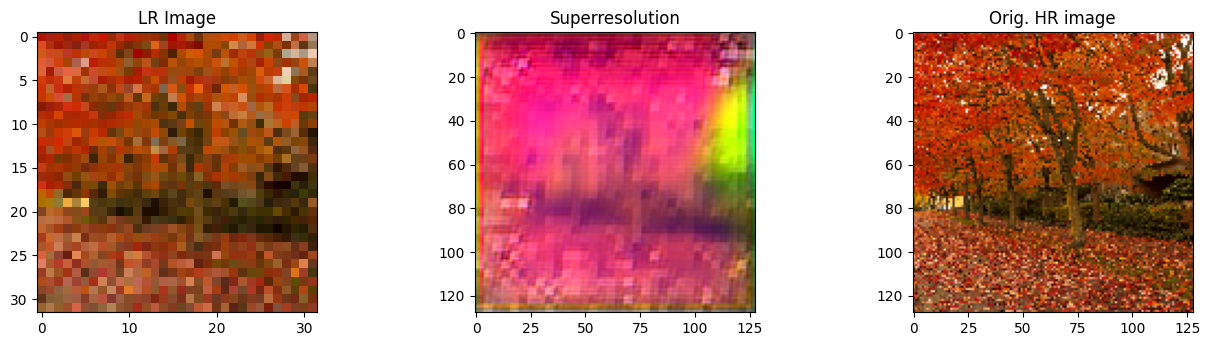

In [10]:
#Test - perform super resolution using saved generator model
# from keras.models import load_model
from numpy.random import randint

# generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


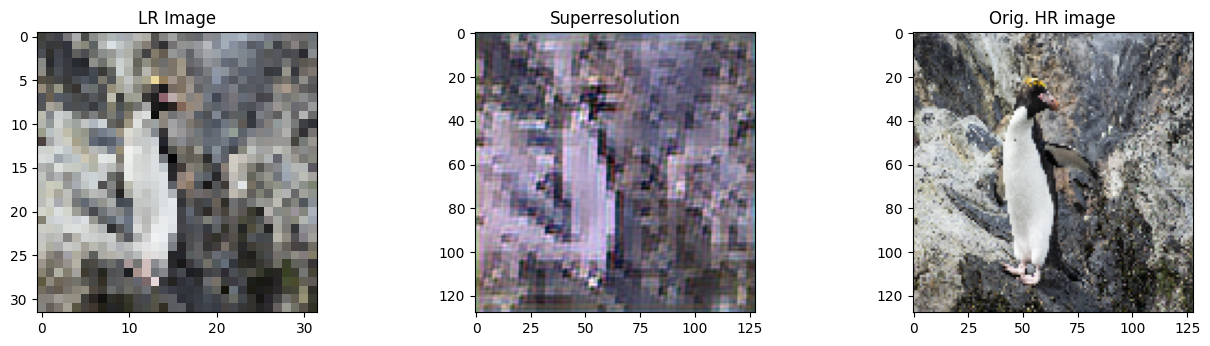

In [11]:
################################################
sreeni_lr = cv2.imread(r"C:\iitb\SOC_2023_ESRGAN\Datasets\lr_images\0801.png")
sreeni_hr = cv2.imread(r"C:\iitb\SOC_2023_ESRGAN\Datasets\hr_images\0801.png")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()